# Automatic Extraction of Fine Structural Information in ARPES by Multi-Stage Clustering Algorithm

Lingzhu Bian, Chen Liu, Zhen Zhang, Yingke Huang, Xinyu Pan, Yi Zhang, Jiaou Wang, Zhesheng Chen, Yuhui Dong  

Correspondence should be addressed to Lingzhu Bian (bianlz@ihep.ac.cn)

# Part 1: Data Loading and pre-processing

 ### - Module Setting

In [1]:
import warnings
import os
import h5py
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import time
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,calinski_harabasz_score
from gap_statistic import OptimalK
import math
warnings.filterwarnings('ignore')
os.environ['OMP_NUM_THREADS'] = '8'
np.set_printoptions(threshold=np.inf)

### - Plot Setting

In [2]:
col_arr = ["gray","orange","brown","blue","purple", "violet"]
fontsize1=40
fontsize2=35
markershape="o"
markersize=25
plt.rcParams['font.family'] = 'Times New Roman'

## (1-i) Load Data

### - Load data and initial settings

In [3]:
file = h5py.File("RealData.h5", 'r')
dataset = file['data']  
mapdata = dataset[:]  


# Size
xn = np.shape(mapdata)[0] # x-axis  
yn = np.shape(mapdata)[1] # y-axis
en = np.shape(mapdata)[2] # Energies
an = np.shape(mapdata)[3] # Angles
pn = xn * yn

# X axis
x_ini = 75
x_end = 165
xw = x_end-x_ini # Width 
dx = 1 # Step

# Y axis
y_ini = 175
y_end = 256
yw =y_end-y_ini  # Width
dy = 1.0125 # Step

# Mapping axes will be rescaled w.r.t. center of the image
k = 0
xpos = np.zeros(xn*yn)
ypos = np.zeros(xn*yn)
for i in range(xn):
    for j in range(yn):
        xpos[k] = -xw/2 + i*dx 
        ypos[k] = -yw/2 + j*dy 
        k += 1
    
# Energy/Angle axis
eng_ini = 84.9599
eng_end = 99.9160
engbins = 889

ang_ini = -20.0431     
ang_end = 6.6810
angbins = 32

eng = np.zeros(engbins)
for i in range(engbins):
    eng[i]=eng_ini+(eng_end-eng_ini)/(engbins-1)*i
ang = np.zeros(angbins)
for i in range(angbins):
    ang[i]=ang_ini+(ang_end-ang_ini)/(angbins-1)*i



print("Load File:", "RealData.h5")
print("\r")
print("---Data Size---")
print("Map Axis 1 :", xn)
print("Map Axis 2 :", yn)
print("Energy :", en)
print("Angle :", an)
print("Energy (start, end):", eng_ini, eng_end)
print("Angle (start, end):", ang_ini, ang_end)
print("eng:", eng)
print("ang:", ang)
print("\r")

Load File: RealData.h5

---Data Size---
Map Axis 1 : 91
Map Axis 2 : 81
Energy : 889
Angle : 32
Energy (start, end): 84.9599 99.916
Angle (start, end): -20.0431 6.681
eng: [84.9599     84.97674245 84.99358491 85.01042736 85.02726982 85.04411227
 85.06095473 85.07779718 85.09463964 85.11148209 85.12832455 85.145167
 85.16200946 85.17885191 85.19569437 85.21253682 85.22937928 85.24622173
 85.26306419 85.27990664 85.2967491  85.31359155 85.33043401 85.34727646
 85.36411892 85.38096137 85.39780383 85.41464628 85.43148874 85.44833119
 85.46517365 85.4820161  85.49885856 85.51570101 85.53254347 85.54938592
 85.56622838 85.58307083 85.59991329 85.61675574 85.6335982  85.65044065
 85.66728311 85.68412556 85.70096802 85.71781047 85.73465293 85.75149538
 85.76833784 85.78518029 85.80202275 85.8188652  85.83570766 85.85255011
 85.86939257 85.88623502 85.90307748 85.91991993 85.93676239 85.95360484
 85.9704473  85.98728975 86.00413221 86.02097466 86.03781712 86.05465957
 86.07150203 86.08834448 86

### - Spatial map of total ARPES intensity 

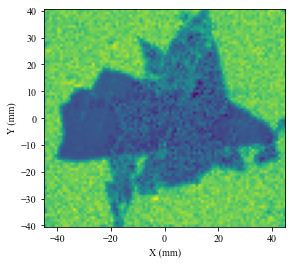

In [4]:
tot_map = np.sum(np.sum(mapdata, axis = 3), axis = 2)
# plot image
fig, ax = plt.subplots()
ax.imshow(tot_map.T, extent = [-xw/2, xw/2, -yw/2, yw/2], origin='lower')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.show()
fig.savefig('plots/initial.pdf', dpi=300, bbox_inches='tight')
fig.savefig('plots/initial.png', dpi=300, bbox_inches='tight')

### - Flatten 4D map to 2D image (iEDCs) 

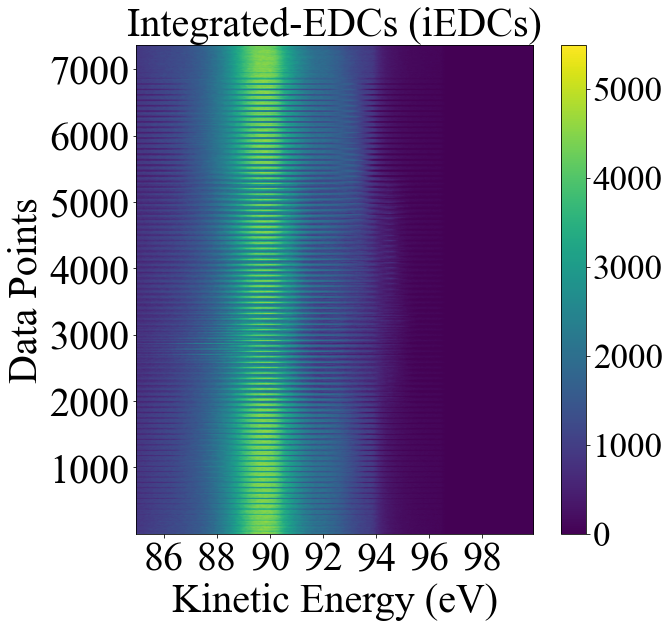

In [5]:
iEDCs = np.sum(mapdata, axis = 3).reshape(xn*yn, en) 
np.savetxt('iEDCs.txt', iEDCs)

fig = plt.figure(figsize=(10,9))
plt.rcParams['font.family'] = 'Times New Roman'
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(iEDCs, extent = [eng_ini, eng_end, 1, xn*yn], aspect = 0.0025)
cbar = fig.colorbar(im)

plt.xlabel('Kinetic Energy (eV)',fontsize=fontsize1)
plt.ylabel('Data Points',fontsize=fontsize1)
plt.title("Integrated-EDCs (iEDCs)",fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)
cbar.ax.tick_params(labelsize=fontsize2)
fig = plt.gcf()
plt.show()
fig.savefig('plots/iEDCs.pdf', dpi=300, bbox_inches='tight')
fig.savefig('plots/iEDCs.png', dpi=300, bbox_inches='tight')

### - Check one ARPES image

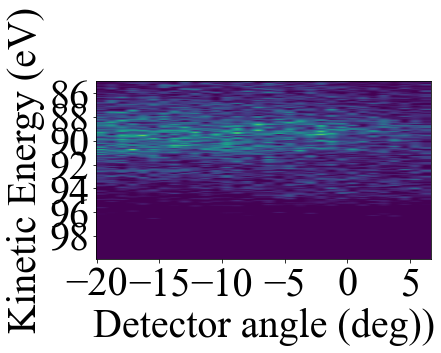

In [6]:
ARPES = np.array(mapdata)[50][22]

# plot image
fig, ax = plt.subplots()
ax.imshow(ARPES, extent = [ang_ini, ang_end, eng_end, eng_ini], aspect = 0.95)
plt.ylabel('Kinetic Energy (eV)',fontsize=fontsize1)
plt.xlabel('Detector angle (deg))',fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)
plt.show()
fig.savefig('plots/initialARPES.pdf', dpi=300, bbox_inches='tight')
fig.savefig('plots/initialARPES.png', dpi=300, bbox_inches='tight')


## (1-ii) Truth Table

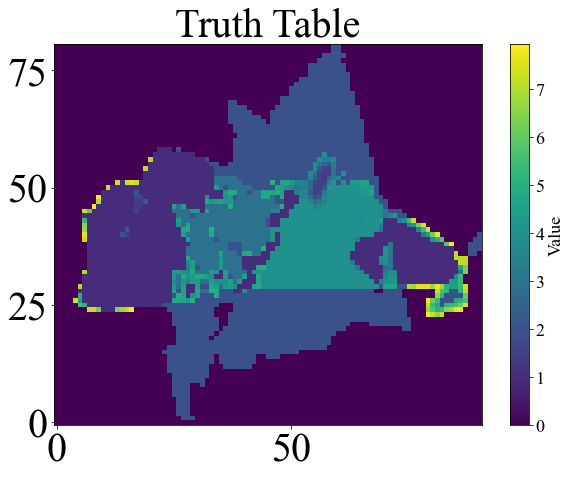

In [7]:
file_TT = h5py.File("truth_table.h5", 'r')
dataset_TT = file_TT['s2']  
TruthTable = dataset_TT[:]  
TruthTable = np.where(TruthTable == 2, 1, np.where(TruthTable == 1, 2, TruthTable))

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(TruthTable.T, origin='lower')
ax.tick_params(axis='both', which='major', labelsize=fontsize1) 
ax.set_title("Truth Table", fontsize=fontsize1, fontname='Times New Roman')
cbar = plt.colorbar(im)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('Value', fontsize=18)
plt.show()
fig.savefig('plots/Truth_Table.pdf', dpi=300, bbox_inches='tight')
fig.savefig('plots/Truth_Table.png', dpi=300, bbox_inches='tight')

## (1-iii) Function of calculating performance metrics

In [8]:
filename = "metrics_main.txt"
with open(filename, "w") as file:  
    file.write("Metrics:\n")

def calculate_metrics(nk, comment, TruthTable, km_results):
    with open(filename, "a") as file:  # Use "a" mode to append to the file
        if comment is None:
            file.write("nk = {}".format(nk) + "\n")  # Add a new line after each output
        elif nk is None:
            file.write(comment + "\n")  # Add a new line after each output

    # Overall Accuracy
    equal_elements = TruthTable == km_results.reshape(91,81)
    similarity_rate = np.mean(equal_elements)
    print("Overall Accuracy: ", similarity_rate)
    output_text = "Overall Accuracy: {}".format(similarity_rate)
    with open(filename, "a") as file:  # Use "a" mode to append to the file
            file.write(output_text + "\n")  # Add a new line after each output
    
    sample = ["Au", "BN", "MoS2-Au", "1-MoS2", "m-MoS2"]
    for i in range(len(sample)):
        sample_TruthTable = np.where(TruthTable == i, 1, 0)
        sample_prediction = np.where(km_results.reshape(91,81) == i, 1, 0)

        TP = np.sum((sample_TruthTable == 1) & (sample_prediction == 1))
        FN = np.sum((sample_TruthTable == 1) & (sample_prediction == 0))
        FP = np.sum((sample_TruthTable == 0) & (sample_prediction == 1))
        TN = np.sum((sample_TruthTable == 0) & (sample_prediction == 0))

        if TP+FN+FP+TN != 0:
            Accuracy = (TP+TN)/(TP+FN+FP+TN)
        else:
            Accuracy = 0

        if TP+FP != 0:
            Precision = TP/(TP+FP)
        else:
            Precision = 0

        if TP+FN != 0:
            Recall = TP/(TP+FN)
        else:
            Recall = 0

        if Precision + Recall != 0:
            F1 = 2 * Precision * Recall / (Precision + Recall)
        else:
            F1 = 0

        print("Accuracy, Precision, Recall and F1 of {}: ".format(sample[i]), Accuracy, Precision, Recall, F1)
        output_text = "Accuracy, Precision, Recall and F1 of {}: {}, {}, {}, {}".format(sample[i], Accuracy, Precision, Recall, F1)
        with open(filename, "a") as file:  # Use "a" mode to append to the file
            file.write(output_text + "\n")  # Add a new line after each output

# Part 2: iEDCs K-means clustering

## (2-i) Select iEDCs as the clustering input

In [9]:
#Select iEDCs as the clustering input
targetMap = iEDCs
slice_axis = eng
sn = np.shape(eng)[0]

## (2-ii) Find the optimal clustering number

### - Silhouette Score

In [10]:
t1 = time.time() 

max_nk = 10
silhouette_scores = np.zeros(max_nk-1)
xsilhouette_scores = np.zeros(max_nk-1)

for i in range(max_nk-1):
    curnk = i + 2
    km = KMeans(n_clusters=curnk, init='random', n_init=10, max_iter=100, random_state=0)
    km_model = km.fit(targetMap)
    km_labels = km_model.labels_
    silhouette_scores[i] = silhouette_score(targetMap, km_labels)  
    xsilhouette_scores[i] = curnk

t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)

Elapsed Time:  31.780293703079224


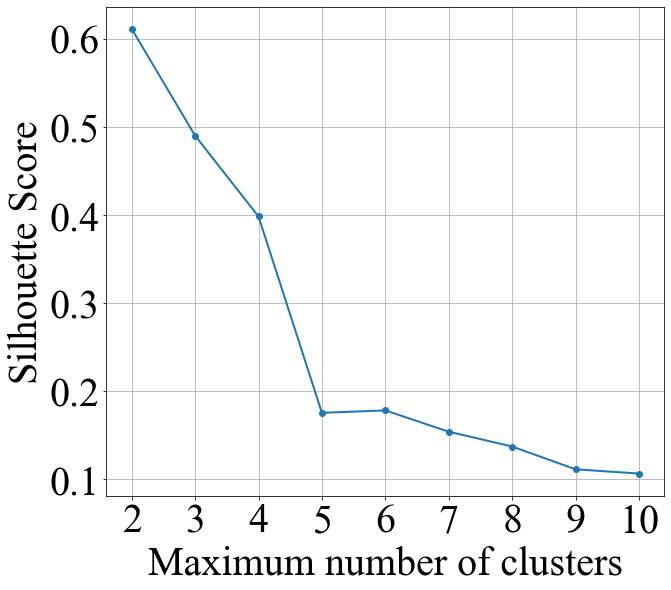

In [11]:
fig = plt.figure(figsize=(10,9))
plt.plot(xsilhouette_scores, silhouette_scores, marker="o",linewidth=2)
plt.grid(True)
plt.xlabel('Maximum number of clusters',fontsize=fontsize1)
plt.ylabel('Silhouette Score',fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)

ax=plt.gca()
ax.yaxis.get_offset_text().set_fontsize(fontsize1)
plt.show()
fig.savefig('plots/initialSil.pdf', dpi=300, bbox_inches='tight')
fig.savefig('plots/initialSil.png', dpi=300, bbox_inches='tight')

### - Gap Statistics

In [12]:
t1 = time.time() 
targetMap = targetMap.astype(float)
max_nk = 10
optimalK = OptimalK()
n_clusters = optimalK(targetMap, n_refs=50, cluster_array=np.arange(1, max_nk+1))

km_gs_gapval = optimalK.gap_df["gap_value"].to_numpy()
km_gs_diff = optimalK.gap_df["diff"].to_numpy()
km_gs_cls = optimalK.gap_df["n_clusters"].to_numpy()

t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)

Elapsed Time:  113.33667850494385


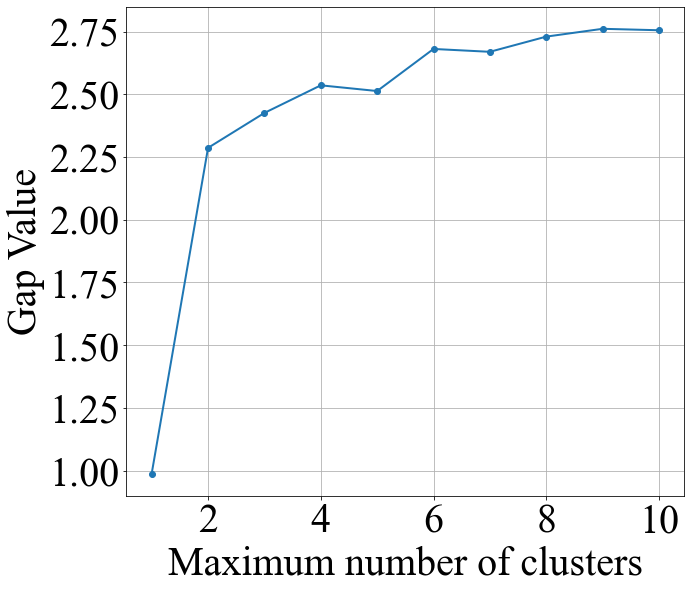

In [13]:
fig = plt.figure(figsize=(10,9))
plt.plot(km_gs_cls, km_gs_gapval, marker="o",linewidth=2)
plt.grid(True)
plt.xlabel('Maximum number of clusters',fontsize=fontsize1)
plt.ylabel('Gap Value',fontsize=fontsize1)
plt.grid(True)
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)

ax=plt.gca()
ax.yaxis.get_offset_text().set_fontsize(fontsize1)
plt.show()
fig.savefig('plots/initialGap.pdf', dpi=300, bbox_inches='tight')
fig.savefig('plots/initialGap.png', dpi=300, bbox_inches='tight')

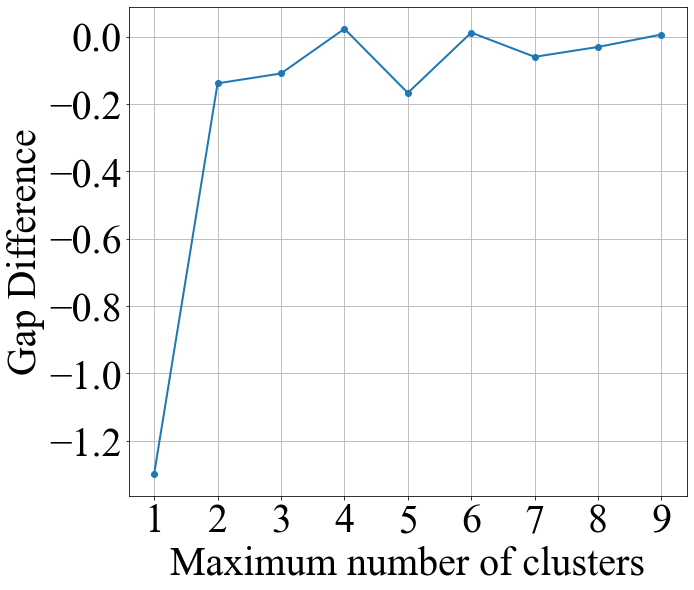

In [14]:
fig = plt.figure(figsize=(10,9))
plt.plot(km_gs_cls, km_gs_diff, marker="o",linewidth=2)
plt.grid(True)
plt.xlabel('Maximum number of clusters',fontsize=fontsize1)
plt.ylabel('Gap Difference',fontsize=fontsize1)
plt.grid(True)
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)

ax=plt.gca()
ax.yaxis.get_offset_text().set_fontsize(fontsize1)
plt.show()
fig.savefig('plots/initialGapdiff.pdf', dpi=300, bbox_inches='tight')
fig.savefig('plots/initialGapdiff.png', dpi=300, bbox_inches='tight')

### - Elbow curve

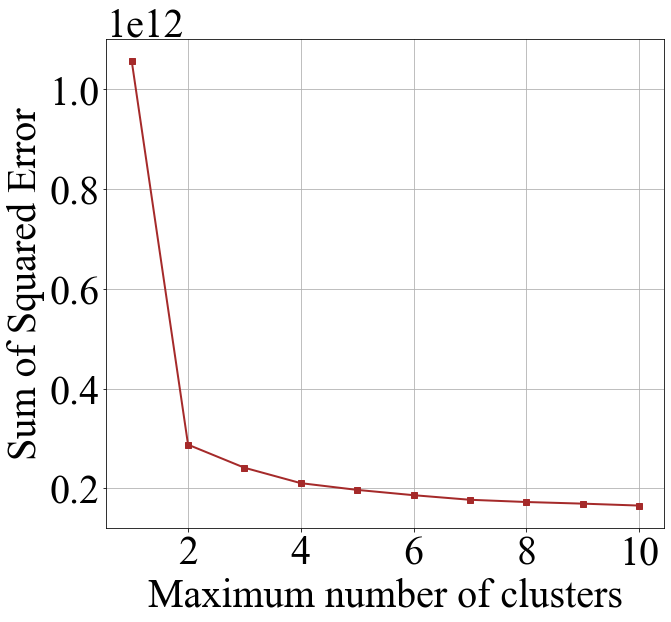

Elapsed Time:  18.036969423294067


In [15]:
t1 = time.time() 

max_nk = 10
sse = np.zeros(max_nk)
xsse = np.zeros(max_nk)

for i in range(max_nk):
    curnk = i + 1 
    km = KMeans(n_clusters=curnk, init='random', n_init=10, max_iter=100, random_state=0)
    km_model = km.fit(targetMap)
    sse[i] = km_model.inertia_ 
    xsse[i] = curnk

fig = plt.figure(figsize=(10,9))
plt.plot(xsse, sse, marker='s', color='brown',linewidth=2)
plt.grid(True)
plt.xlabel('Maximum number of clusters',fontsize=fontsize1)
plt.ylabel('Sum of Squared Error',fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)

ax=plt.gca()
ax.yaxis.get_offset_text().set_fontsize(fontsize1)
plt.show()
fig.savefig('plots/initialSSE.pdf', dpi=300, bbox_inches='tight')
fig.savefig('plots/initialSSE.png', dpi=300, bbox_inches='tight')

t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)

## (2-iii) Perform clustering

### - Choose the number of cluster as you want  (n=2)

In [16]:
nk=2

### - clustering and save the result

In [17]:
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_

resultsfile = f'kmresults_{nk}.npy'
np.save(resultsfile,km_results)

### - Spatial Distribution of clusters

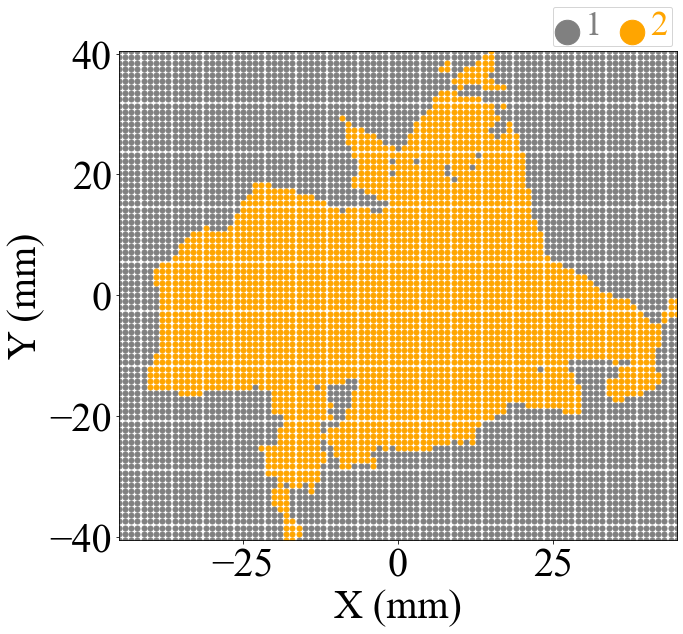

In [18]:
fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(1, 1, 1)
     
for i in range(nk):
    x = []
    y = []
    for j in range(pn):
        curcln = km_results[j]
        if i == curcln:
            x = np.append(x, xpos[j])
            y = np.append(y, ypos[j])
        if j == pn-1:
            ax.scatter(x, y, marker=markershape, s=markersize, c = col_arr[i], label=str(i+1))
            
ax.set_xlim(-xw/2, xw/2)  
ax.set_ylim(-yw/2, yw/2)  
ax.tick_params(axis='both', which='major', labelsize=fontsize1) 
ax.set_xlabel('X (mm)', fontsize=fontsize1, fontname='Times New Roman')
ax.set_ylabel('Y (mm)', fontsize=fontsize1, fontname='Times New Roman')

# Legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, loc='upper right',bbox_to_anchor=(1,1.1),ncol=nk+1)
i = 0
for text in legend.get_texts():
    text.set_fontsize(fontsize2)
    text.set_fontname('Times New Roman')
    text.set_color(col_arr[i])
    i = i+1
i = 0
for handle in legend.legendHandles:
    handle.set_color(col_arr[i])  
    handle.set_sizes([600])   
    i = i+1

plt.show()
fig.savefig('plots/clustering_result_2.pdf', dpi=300, bbox_inches='tight')
fig.savefig('plots/clustering_result_2.png', dpi=300, bbox_inches='tight')  

### - calculate the performance matrics

In [19]:
calculate_metrics(nk, None, TruthTable, km_results)

Overall Accuracy:  0.6864740198073531
Accuracy, Precision, Recall and F1 of Au:  0.9705603038936372 0.9524783992723965 0.9980938765785085 0.9747527632344386
Accuracy, Precision, Recall and F1 of BN:  0.7141500474833808 0.29297006390850994 0.9942922374429224 0.45258508703559364
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.8247184913851581 0 0.0 0
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.9652692986026319 0 0.0 0
Accuracy, Precision, Recall and F1 of m-MoS2:  0.9462759462759462 0 0.0 0


### - Integrated EDC within each cluster

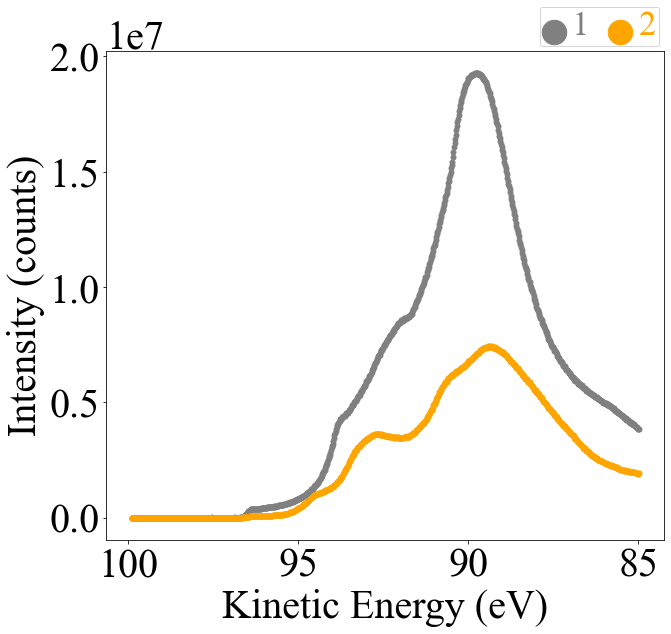

In [20]:
fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(1, 1, 1)

intSlices = np.zeros((nk, sn))
for i in range(nk):
    # Initialization for each cluster number 
    curslice = np.zeros(sn) # 1D y wave  
    for j in range(pn):  ## go through all positions x*y
        curcln = km_results[j]  
        if i == curcln:
            curslice += targetMap[j]
        if j == pn-1:
            # First and Last data point is replaced by NaN because of artifactual rapid intesity drop reflecting both edges of the detector
            curslice[0] = np.nan; curslice[sn-1] = np.nan
            intSlices[i][:] = curslice # for saving
            ax.scatter(slice_axis, curslice, marker=markershape, c = col_arr[i], s=markersize, label=str(i+1))
ax.invert_xaxis()
ax.tick_params(axis='both', which='major', labelsize=fontsize1) 
ax.set_xlabel('Kinetic Energy (eV)', fontsize=fontsize1, fontname='Times New Roman')
ax.set_ylabel('Intensity (counts)', fontsize=fontsize1, fontname='Times New Roman')
ax.ticklabel_format(style="sci")
ax.yaxis.get_offset_text().set_fontsize(fontsize1)

# Legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, loc='upper right',bbox_to_anchor=(1,1.1),ncol=nk+1)
i = 0
for text in legend.get_texts():
    text.set_fontsize(fontsize2)
    text.set_fontname('Times New Roman')
    text.set_color(col_arr[i])
    i = i+1
i = 0
for handle in legend.legendHandles:
    handle.set_color(col_arr[i])  
    handle.set_sizes([600])   
    i = i+1
plt.show()
fig.savefig('plots/EDC_curve_2.pdf', dpi=300, bbox_inches='tight')
fig.savefig('plots/EDC_curve_2.png', dpi=300, bbox_inches='tight')

### - Integrated ARPES image within each cluster

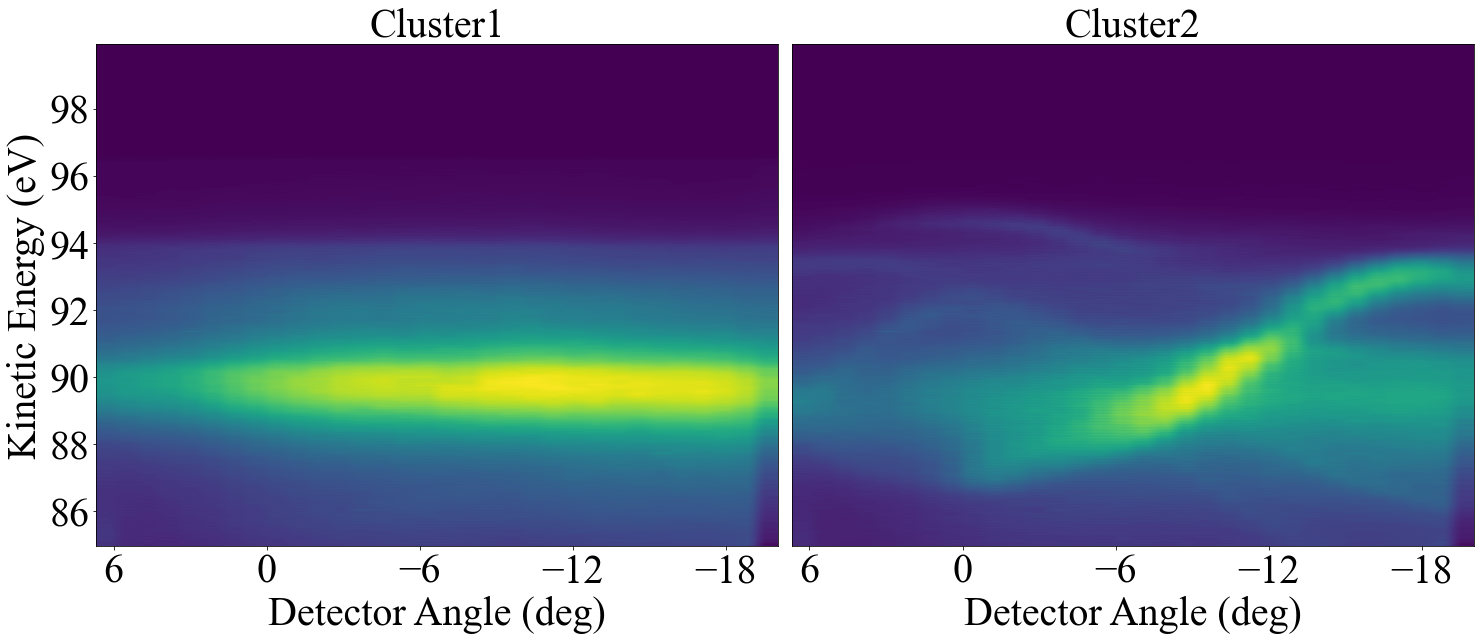

In [21]:
iARPESs = np.zeros((nk, en, an))

for i in range(pn):
    curcln = km_results[i]  
    curRow = math.floor(i/yn)  # the row of positon i
    curCol = i % yn            # the column of positon i
    iARPESs[curcln][:][:] += mapdata[curRow][curCol][:][:]
        
n_col = 4 # Set to adjust your screen
n_row = math.ceil(nk/n_col)
fig = plt.figure(figsize=(10*n_col, 9*n_row))

for i in range(nk):
    iARPES = np.zeros((en, an))
    iARPES = np.flip(iARPESs[i])
    curax = fig.add_subplot(n_row, n_col, i+1)
    plt.xticks(fontsize=fontsize1)
    plt.yticks(fontsize=fontsize1)
    curax.set_title("Cluster"+str(i+1), fontsize=fontsize1)
    curax.set_xlabel('Detector Angle (deg)', fontsize=fontsize1)
    if i==0:
        curax.set_ylabel('Kinetic Energy (eV)', fontsize=fontsize1)
    if i!=0:
        curax.set_yticks([])   
    plt.imshow(iARPES, aspect="auto", extent= [ang_end, ang_ini, eng_ini, eng_end])
    plt.xticks([6, 0, -6, -12, -18])

fig.tight_layout()
plt.show()
fig.savefig('plots/2D_image_2.pdf', dpi=300)
fig.savefig('plots/2D_image_2.png', dpi=300)

### - Choose the number of cluster as you want  (n=4)

In [22]:
nk=4

### - clustering and save the result

In [23]:
km = KMeans(n_clusters=nk, n_init=10, random_state=100)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 

label_mapping = {2: 0, 0: 3, 3: 1, 1: 2}
km_results = np.array([label_mapping[label] for label in km_results])
resultsfile = f'kmresults_{nk}.npy'
np.save(resultsfile,km_results)

### - Spatial Distribution of clusters and save the postions of each cluster

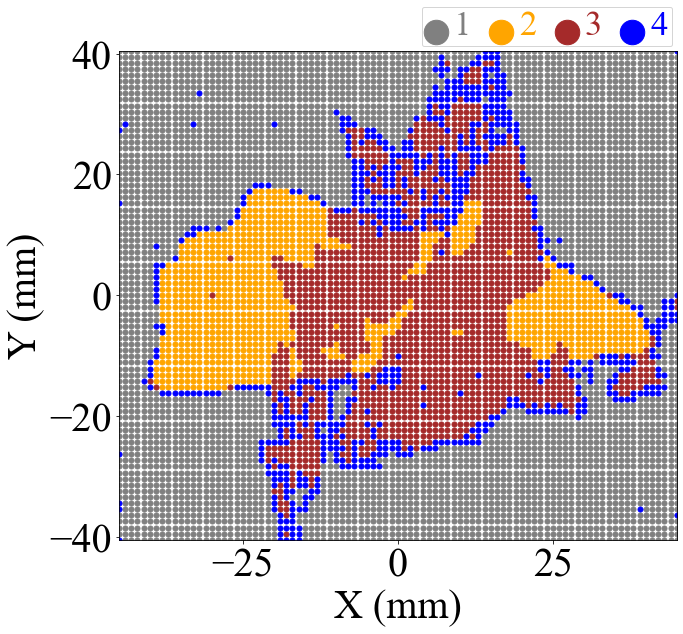

In [24]:
fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(1, 1, 1)
for i in range(nk):
    x = []
    y = []
    for j in range(pn):
        curcln = km_results[j]
        if i == curcln:
            x = np.append(x, xpos[j])
            y = np.append(y, ypos[j])
        if j == pn-1:
            ax.scatter(x, y, marker=markershape, s=markersize, c = col_arr[i],label=str(i+1))
            
ax.set_xlim(-xw/2, xw/2)  
ax.set_ylim(-yw/2, yw/2)  
ax.tick_params(axis='both', which='major', labelsize=fontsize1)  
ax.set_xlabel('X (mm)', fontsize=fontsize1, fontname='Times New Roman')
ax.set_ylabel('Y (mm)', fontsize=fontsize1, fontname='Times New Roman')

# Legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, loc='upper right',bbox_to_anchor=(1,1.1),ncol=nk+1)
i = 0
for text in legend.get_texts():
    text.set_fontsize(fontsize2)
    text.set_fontname('Times New Roman')
    text.set_color(col_arr[i])
    i = i+1
i = 0
for handle in legend.legendHandles:
    handle.set_color(col_arr[i])  
    handle.set_sizes([600])   
    i = i+1

plt.show()
fig.savefig('plots/clustering_result_4.pdf', dpi=300, bbox_inches='tight')
fig.savefig('plots/clustering_result_4.png', dpi=300, bbox_inches='tight')

### - calculate the performance matrics

In [25]:
 calculate_metrics(nk, None,TruthTable, km_results)

Overall Accuracy:  0.7741147741147741
Accuracy, Precision, Recall and F1 of Au:  0.9826346493013159 0.9922574401161384 0.9771265189421015 0.9846338535414165
Accuracy, Precision, Recall and F1 of BN:  0.9787003120336454 0.8796198521647307 0.9509132420091324 0.913878222709819
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.8194274860941527 0.48768161718256475 0.5975232198142415 0.5370434782608696
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.8692172025505359 0.0 0.0 0
Accuracy, Precision, Recall and F1 of m-MoS2:  0.9462759462759462 0 0.0 0


### - Integrated EDC within each cluster

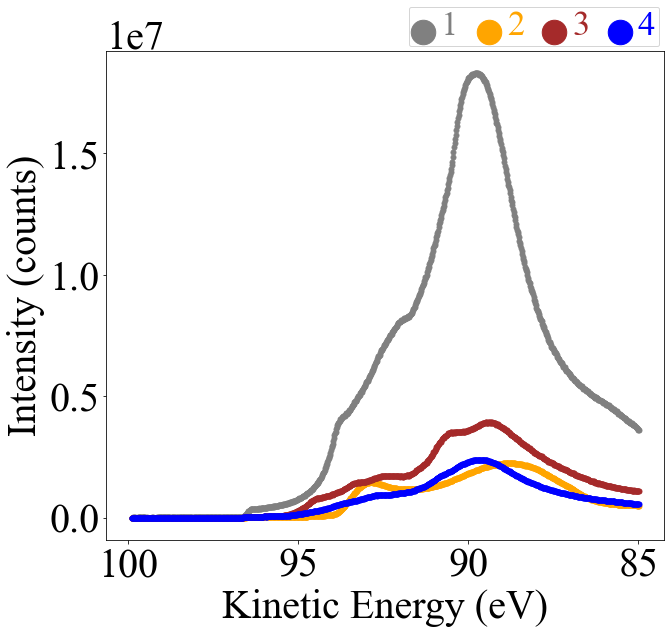

In [26]:
fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(1, 1, 1)

intSlices = np.zeros((nk, sn))
for i in range(nk):
    # Initialization for each cluster number 
    curslice = np.zeros(sn) # 1D y wave  
    for j in range(pn):  ## go through all positions x*y
        curcln = km_results[j]  
        if i == curcln:
            curslice += targetMap[j]
        if j == pn-1:
            # First and Last data point is replaced by NaN because of artifactual rapid intesity drop reflecting both edges of the detector
            curslice[0] = np.nan; curslice[sn-1] = np.nan
            intSlices[i][:] = curslice # for saving
            ax.scatter(slice_axis, curslice, marker=markershape, c = col_arr[i], s=markersize, label=str(i+1))
ax.invert_xaxis()
ax.tick_params(axis='both', which='major', labelsize=fontsize1) 
ax.set_xlabel('Kinetic Energy (eV)', fontsize=fontsize1, fontname='Times New Roman')
ax.set_ylabel('Intensity (counts)', fontsize=fontsize1, fontname='Times New Roman')
ax.ticklabel_format(style="sci")
ax.yaxis.get_offset_text().set_fontsize(fontsize1)

# Legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, loc='upper right',bbox_to_anchor=(1,1.1),ncol=nk+1)
i = 0
for text in legend.get_texts():
    text.set_fontsize(fontsize2)
    text.set_fontname('Times New Roman')
    text.set_color(col_arr[i])
    i = i+1
i = 0
for handle in legend.legendHandles:
    handle.set_color(col_arr[i])  
    handle.set_sizes([600])   
    i = i+1

plt.show()
fig.savefig('plots/EDC_curve_4.pdf', dpi=300, bbox_inches='tight')
fig.savefig('plots/EDC_curve_4.png', dpi=300, bbox_inches='tight')

### - Integrated ARPES image within each cluster

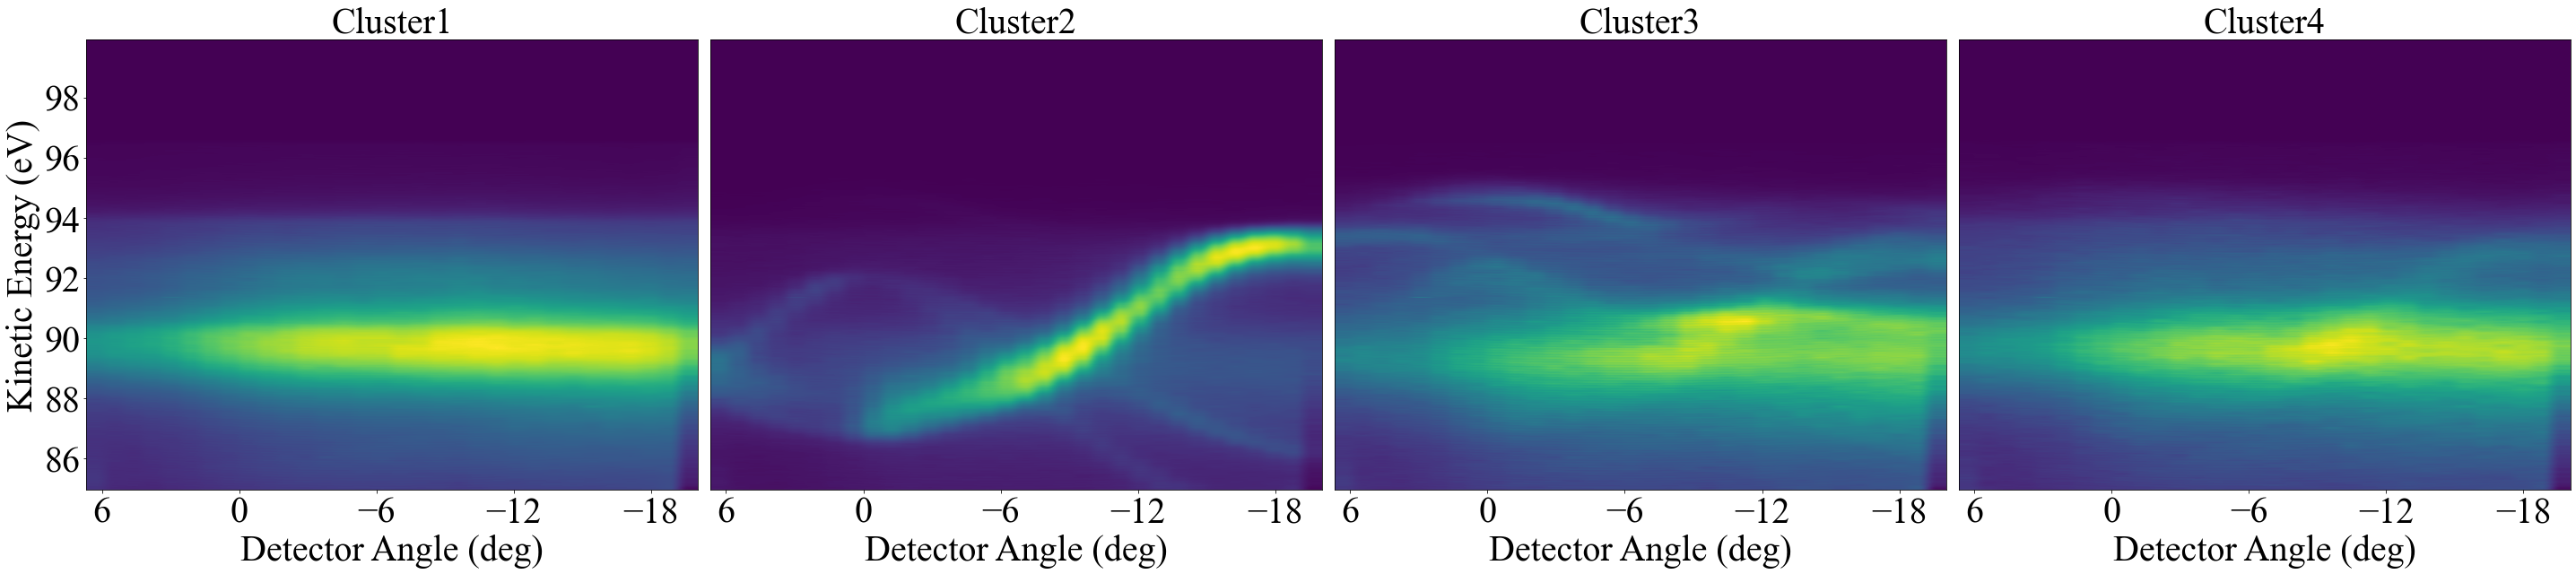

In [27]:
iARPESs = np.zeros((nk, en, an))
for i in range(pn):
    curcln = km_results[i] 
    curRow = math.floor(i/yn)  # the row of positon i
    curCol = i % yn            # the column of positon i
    iARPESs[curcln][:][:] += mapdata[curRow][curCol][:][:]
    

n_col = 4 # Set to adjust your screen
n_row = math.ceil(nk/n_col)
fig = plt.figure(figsize=(10*n_col, 9*n_row))

for i in range(nk):
    iARPES = np.zeros((en, an))
    iARPES =np.flip(iARPESs[i])
    curax = fig.add_subplot(n_row, n_col, i+1)
    curax.set_title("Cluster"+str(i+1))
    plt.xticks(fontsize=fontsize1)
    plt.yticks(fontsize=fontsize1)
    curax.set_title("Cluster"+str(i+1), fontsize=fontsize1)
    curax.set_xlabel('Detector Angle (deg)', fontsize=fontsize1)
    if i==0:
        curax.set_ylabel('Kinetic Energy (eV)', fontsize=fontsize1)
    if i!=0:
        curax.set_yticks([])   
    plt.imshow(iARPES, aspect="auto", extent= [ang_end, ang_ini, eng_ini, eng_end])
    plt.xticks([6, 0, -6, -12, -18])
    
fig.tight_layout()
plt.show()
fig.savefig('plots/2D_image_4.pdf', dpi=300)
fig.savefig('plots/2D_image_4.png', dpi=300)

### - Choose the number of cluster as you want  (n=3)

In [28]:
nk=3

### - clustering and save the result

In [29]:
km = KMeans(n_clusters=nk, n_init=10, random_state=100)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
km_results_of_each_cluster = np.zeros((nk,pn))

#Change the labels of different clustering, just for ploting
label_mapping = {2: 1, 1: 2, 0:0}
km_results = np.array([label_mapping[label] for label in km_results])
resultsfile = f'kmresults_{nk}.npy'
np.save(resultsfile,km_results)

### - Spatial Distribution of clusters and save the postions of each cluster

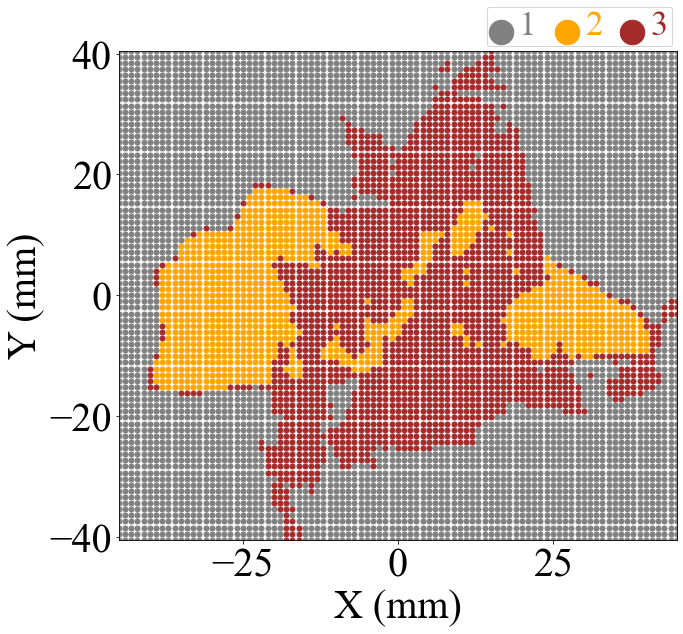

In [30]:
fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(1, 1, 1)
x_nk3 = []
y_nk3 = []
for i in range(nk):
    x = []
    y = []
    for j in range(pn):
        curcln = km_results[j]
        if i == curcln:
            km_results_of_each_cluster[i][j] = i
            x = np.append(x, xpos[j])
            y = np.append(y, ypos[j])
        if j == pn-1:
            ax.scatter(x, y, marker=markershape, s=markersize, c = col_arr[i], label=str(i+1))
            x_nk3.append(x)
            y_nk3.append(y)
            
ax.set_xlim(-xw/2, xw/2)  
ax.set_ylim(-yw/2, yw/2) 
ax.tick_params(axis='both', which='major', labelsize=fontsize1) 
ax.set_xlabel('X (mm)', fontsize=fontsize1, fontname='Times New Roman')
ax.set_ylabel('Y (mm)', fontsize=fontsize1, fontname='Times New Roman')

# Legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, loc='upper right',bbox_to_anchor=(1,1.1),ncol=nk+1)
i = 0
for text in legend.get_texts():
    text.set_fontsize(fontsize2)
    text.set_fontname('Times New Roman')
    text.set_color(col_arr[i])
    i = i+1
i = 0
for handle in legend.legendHandles:
    handle.set_color(col_arr[i])  
    handle.set_sizes([600])   
    i = i+1

plt.show()
fig.savefig('plots/clustering_result_3.pdf', dpi=300, bbox_inches='tight')
fig.savefig('plots/clustering_result_3.png', dpi=300, bbox_inches='tight')

### - calculate the performance matrics

In [31]:
calculate_metrics(nk, None, TruthTable, km_results)

Overall Accuracy:  0.8377425044091711
Accuracy, Precision, Recall and F1 of Au:  0.9735449735449735 0.9585242896425298 0.9966642840123898 0.9772222871159911
Accuracy, Precision, Recall and F1 of BN:  0.9723239723239723 0.8380281690140845 0.9509132420091324 0.8909090909090909
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.8660968660968661 0.5757575757575758 0.8970588235294118 0.7013615733736763
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.9652692986026319 0 0.0 0
Accuracy, Precision, Recall and F1 of m-MoS2:  0.9462759462759462 0 0.0 0


### - Obtain the spatial distribution of MoS2

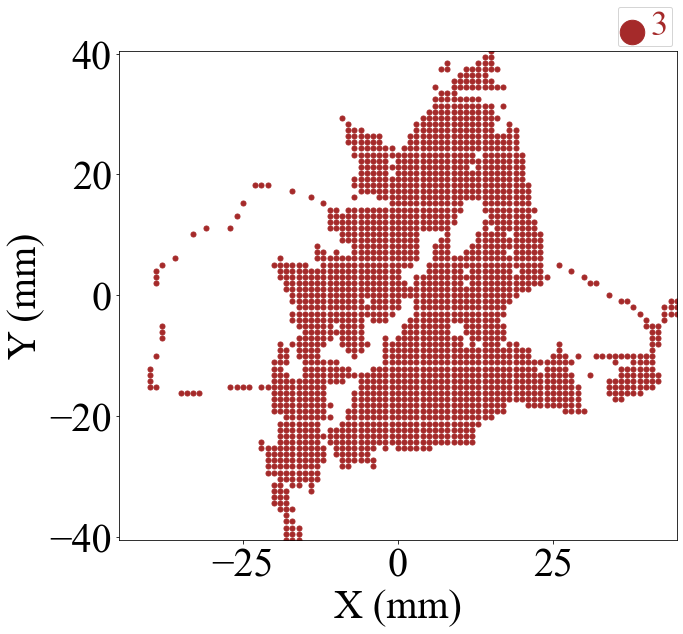

In [32]:
fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(1, 1, 1) 
for i in range(2,3):
    x = []
    y = []
    for j in range(pn):
        curcln = km_results[j]
        if i == curcln:
            x = np.append(x, xpos[j])
            y = np.append(y, ypos[j])
        if j == pn-1:
            data = plt.scatter(x, y, marker=markershape, s=markersize, c = col_arr[i],label=str(i+1))

ax.set_xlim(-xw/2, xw/2)  
ax.set_ylim(-yw/2, yw/2)  
ax.tick_params(axis='both', which='major', labelsize=fontsize1) 
ax.set_xlabel('X (mm)', fontsize=fontsize1, fontname='Times New Roman')
ax.set_ylabel('Y (mm)', fontsize=fontsize1, fontname='Times New Roman')

# Legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, loc='upper right',bbox_to_anchor=(1,1.1),ncol=nk+1)

for text in legend.get_texts():
    text.set_fontsize(fontsize2)
    text.set_fontname('Times New Roman')
    text.set_color(col_arr[2])

for handle in legend.legendHandles:
    handle.set_color(col_arr[2])  
    handle.set_sizes([600])   
    
plt.show()
fig.savefig('plots/spatial_distribution_MoS2.pdf', dpi=300, bbox_inches='tight')
fig.savefig('plots/spatial_distribution_MoS2.png', dpi=300, bbox_inches='tight')


### - Integrated EDC within each cluster

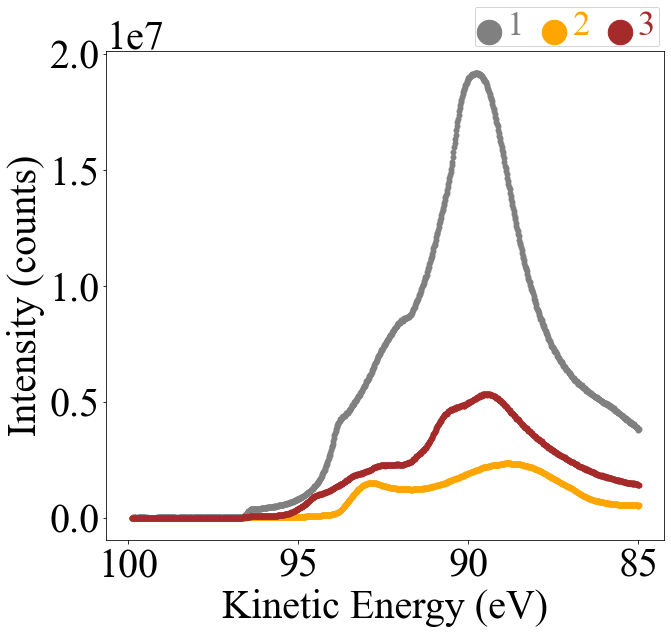

In [33]:
fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(1, 1, 1)

intSlices = np.zeros((nk, sn))
for i in range(nk):
    # Initialization for each cluster number 
    curslice = np.zeros(sn) # 1D y wave  
    for j in range(pn):  ## go through all positions x*y
        curcln = km_results[j]  
        if i == curcln:
            curslice += targetMap[j]
        if j == pn-1:
            # First and Last data point is replaced by NaN because of artifactual rapid intesity drop reflecting both edges of the detector
            curslice[0] = np.nan; curslice[sn-1] = np.nan
            intSlices[i][:] = curslice # for saving
            ax.scatter(slice_axis, curslice, marker=markershape, c = col_arr[i], s=markersize, label=str(i+1))
ax.invert_xaxis()
ax.tick_params(axis='both', which='major', labelsize=fontsize1) 
ax.set_xlabel('Kinetic Energy (eV)', fontsize=fontsize1, fontname='Times New Roman')
ax.set_ylabel('Intensity (counts)', fontsize=fontsize1, fontname='Times New Roman')
ax.ticklabel_format(style="sci")
ax.yaxis.get_offset_text().set_fontsize(fontsize1)

# Legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, loc='upper right',bbox_to_anchor=(1,1.1),ncol=nk+1)
i = 0
for text in legend.get_texts():
    text.set_fontsize(fontsize2)
    text.set_fontname('Times New Roman')
    text.set_color(col_arr[i])
    i = i+1
i = 0
for handle in legend.legendHandles:
    handle.set_color(col_arr[i])  
    handle.set_sizes([600])   
    i = i+1

plt.show()
fig.savefig('plots/EDC_curve_3.pdf', dpi=300, bbox_inches='tight')
fig.savefig('plots/EDC_curve_3.png', dpi=300, bbox_inches='tight')

### - Integrated ARPES image within each cluster

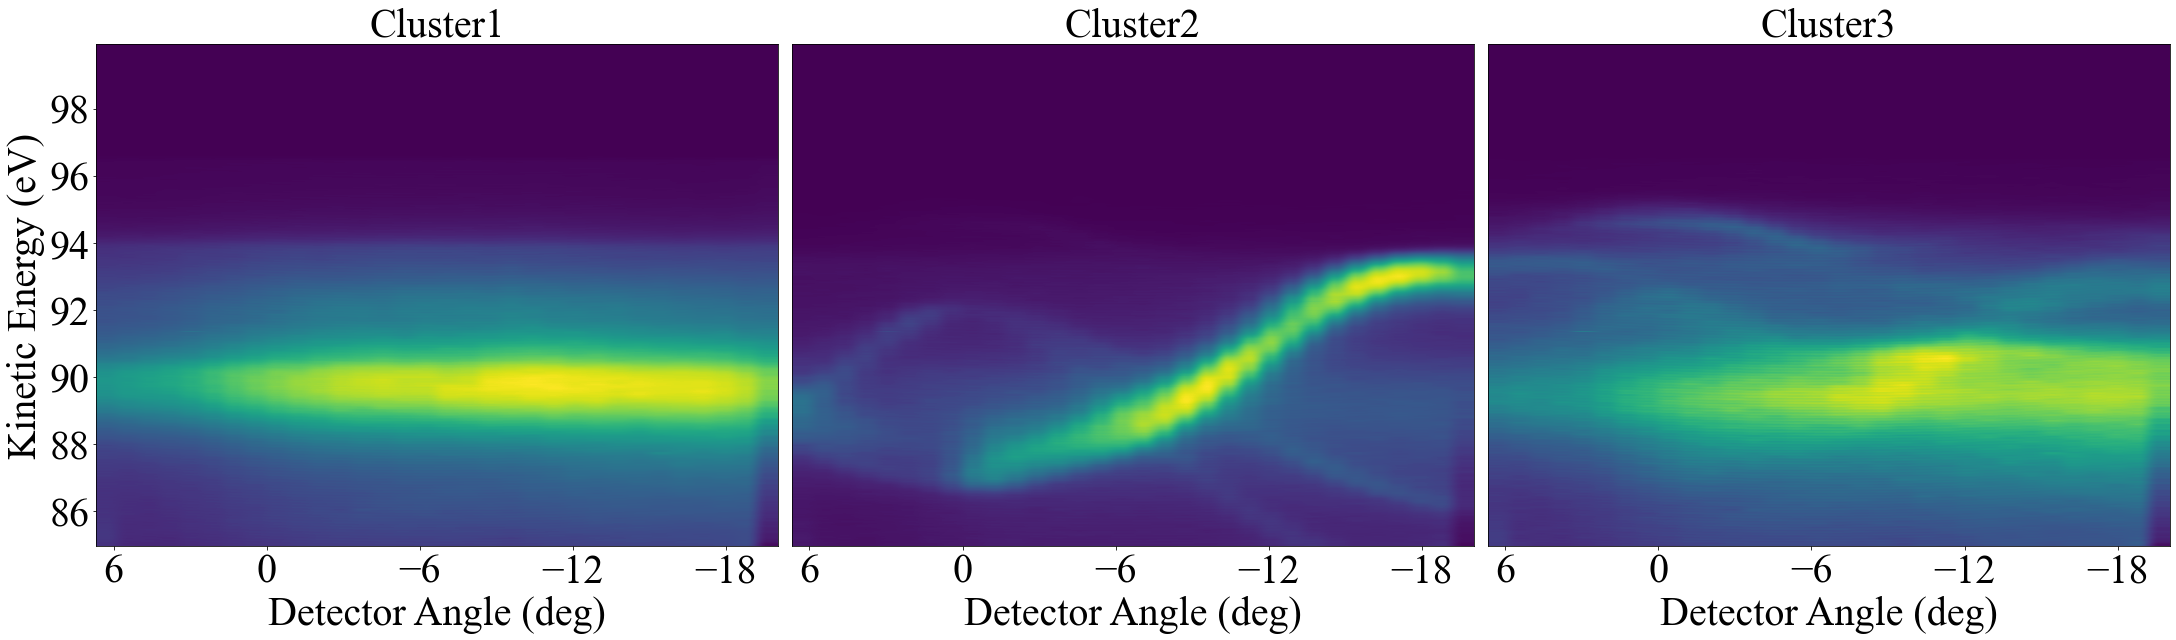

In [34]:
iARPESs = np.zeros((nk, en, an))

for i in range(pn):
    curcln = km_results[i]  
    curRow = math.floor(i/yn)  # the row of positon i
    curCol = i % yn            # the column of positon i
    iARPESs[curcln][:][:] += mapdata[curRow][curCol][:][:]

img = Image.fromarray(iARPESs[1])
img.save('2DImage_MoS2.tiff')
img = Image.fromarray(iARPESs[2])
img.save('2DImage_BN.tiff')


n_col = 4 # Set to adjust your screen
n_row = math.ceil(nk/n_col)
fig = plt.figure(figsize=(10*n_col, 9*n_row))
for i in range(nk):
    iARPES = np.zeros((en, an))
    iARPES =np.flip(iARPESs[i])
    curax = fig.add_subplot(n_row, n_col, i+1)
    curax.set_title("Cluster"+str(i+1))
    plt.xticks(fontsize=fontsize1)
    plt.yticks(fontsize=fontsize1)
    curax.set_title("Cluster"+str(i+1), fontsize=fontsize1)
    curax.set_xlabel('Detector Angle (deg)', fontsize=fontsize1)
    if i==0:
        curax.set_ylabel('Kinetic Energy (eV)', fontsize=fontsize1)
    if i!=0:
        curax.set_yticks([])   
    plt.imshow(iARPES, aspect="auto", extent= [ang_end, ang_ini, eng_ini, eng_end])
    plt.xticks([6, 0, -6, -12, -18])
fig.tight_layout()
plt.show()

fig.savefig('plots/2D_image_3.pdf', dpi=300)
fig.savefig('plots/2D_image_3.png', dpi=300)

# Part 3: Multi-Stage Clustering Algorithm (MSCA)

## (3-i) Self-defined functions for Multi-Stage Clustering Algorithm

In [35]:
# Obtain the index chosen 
def get_location_in_iARPESArray_from_iARPESRange(ang_left,ang_right,eng_left,eng_right,ang,eng):
    arr = np.array(ang)
    condition = arr < ang_left
    if not np.any(condition):
        LR_col = 0
    else:
        indexes = np.where(condition)
        LR_col = indexes[0][-1]

    condition = arr > ang_right
    if not np.any(condition):
        RR_col = len(ang)-1
    else:
        indexes = np.where(condition)
        RR_col = indexes[0][0]
   
    arr = np.array(eng)
    condition = arr < eng_left
    if not np.any(condition):
        LR_row = 0
    else:
        indexes = np.where(condition)
        LR_row = indexes[0][-1]

    condition = arr > eng_right
    if not np.any(condition):
        RR_row = len(eng)-1
    else:
        indexes = np.where(condition)
        RR_row = indexes[0][0]
    
    #print("The range of angle is [%f(%d),%f(%d)], the value of bin %d is %f and bin %d is %f"%(ang[LR_col],LR_col,ang[RR_col],RR_col,LR_col+1,ang[LR_col+1],RR_col-1,ang[RR_col-1]))
    #print("The range of energy is [%f(%d),%f(%d)], the value of bin %d is %f and bin %d is %f"%(eng[LR_row],LR_row,eng[RR_row],RR_row,LR_row+1,eng[LR_row+1],RR_row-1,eng[RR_row-1]))
    
    return LR_col,RR_col,LR_row,RR_row

In [36]:
def get_iARPESs_of_one_cluster(clustering_result,cluster_chosen):
    arr_results = np.array(clustering_result)
    count = np.count_nonzero(arr_results == cluster_chosen-1)
    print("The number of points in cluster%d is "%cluster_chosen, count)

    x_chosen = []
    y_chosen = []
    iARPESs_chosen = np.zeros((count, en, an))

    num = 0
    for i in range(len(clustering_result)):
        curcln = clustering_result[i]  
        if curcln == cluster_chosen - 1:
            curRow = math.floor(i/yn)  # the row of positon i
            curCol = i % yn            # the column of positon i
        
            x_chosen = np.append(x_chosen, xpos[i])
            y_chosen = np.append(y_chosen, ypos[i])
        
            iARPESs_chosen[num][:][:] = mapdata[curRow][curCol][:][:]
            num = num + 1

    return x_chosen, y_chosen, iARPESs_chosen  

In [37]:
def get_iEDCs_of_given_range(ang_left,ang_right,eng_left,eng_right,ang,eng,iARPESs_chosen):
    LR_col,RR_col,LR_row,RR_row = get_location_in_iARPESArray_from_iARPESRange(ang_left,ang_right,eng_left,eng_right,ang,eng)
    new_iARPESs_chosen = np.zeros((iARPESs_chosen.shape[0], RR_row-LR_row+1, RR_col-LR_col+1))
    #print("test: ",new_iARPESs_chosen.shape)
    new_iARPESs_chosen[:][:][:] = iARPESs_chosen[:,LR_row:RR_row+1,LR_col:RR_col+1]
    iEDCs_chosen = np.sum(new_iARPESs_chosen, axis = 2).reshape(new_iARPESs_chosen.shape[0], new_iARPESs_chosen.shape[1]) 
    return iEDCs_chosen 

In [38]:
def calElbow(data,max_nk):    
    sse = np.zeros(max_nk)
    xsse = np.zeros(max_nk)
    
    for i in range(max_nk):
        curnk = i + 1 
        km = KMeans(n_clusters=curnk, init='random', n_init=10, max_iter=100, random_state=0)
        km_model = km.fit(data)
        sse[i] = km_model.inertia_ 
        xsse[i] = curnk
        #print("xsse[i]: ",xsse[i])
        #print("sse, xsse: ",sse,xsse)
    return sse, xsse
    

In [39]:
def plot(xlist,ylist):
 
    plt.figure(figsize=(10,9))
    plt.plot(xlist, ylist, marker="o",linewidth=2)
    plt.grid(True)
    plt.xlabel('Maximum number of clusters')
    plt.ylabel('Sum of Squared Error')
    return plt

In [40]:
def get_sse_matrix(iARPESs_chosen,engstart, engend,angstart, angend,engbin,angbin,max_nk):
    englst = np.linspace(engstart, engend, engbin+1)
    anglst = np.linspace(angstart, angend, angbin+1)
    
    ssematrix = []
    print("engbin,angbin: ", engbin,angbin)
    for i in range(engbin):
        for j in range(angbin):
            angleft = anglst[j]
            angright = anglst[j+1]
            engleft = englst[i]
            engright = englst[i+1]
            iEDCs = get_iEDCs_of_given_range(angleft,angright,engleft,engright,ang,eng,iARPESs_chosen)
            ylist,xlist = calElbow(iEDCs,max_nk)
            ylist = np.divide(ylist, sum(ylist))
            ssematrix.append(ylist)
            print("engbin and angbin are: ",i,j)
        
    ssematrix = np.reshape(ssematrix,(engbin*angbin,max_nk))
    print(ssematrix)
    return ssematrix

In [41]:
def get_sse_curve(maxnk,data):
    ssehh = np.zeros(maxnk)
    xssehh = np.zeros(maxnk)

    for i in range(maxnk):
        curnk = i + 1 
        km = KMeans(n_clusters=curnk, init='random', n_init=10, max_iter=100, random_state=0)
        km_model = km.fit(data)
        ssehh[i] = km_model.inertia_ 
        xssehh[i] = curnk
        
    
    fig = plt.figure(figsize=(10,9))
    plt.plot(xssehh, ssehh, marker='s', color='brown',linewidth=2)
    plt.grid(True)
    plt.xlabel('Maximum number of clusters',fontsize=fontsize1)
    plt.ylabel('Sum of Squared Error',fontsize=fontsize1)
    plt.xticks(fontsize=fontsize1)
    plt.yticks(fontsize=fontsize1)
    ax=plt.gca()
    ax.yaxis.get_offset_text().set_fontsize(fontsize1)
    
    plt.show()
    return fig


In [42]:
def get_important_field(nk, data, angstart, angend, engend, engstart,englist, anglist,label_mapping):
    kmhh = KMeans(n_clusters=nk, n_init=10, random_state=100)
    km_modelhh = kmhh.fit(data)
    km_resultshh = km_modelhh.labels_
    pnhh = len(km_resultshh) 
    if label_mapping is not None:
        label_mapping = label_mapping  
        km_resultshh = np.array([label_mapping[label] for label in km_resultshh])

    fig = plt.figure(figsize=(10,9))
    ax = fig.add_subplot(1, 1, 1)
    pn = len(km_resultshh)

    lengthx=(angend-angstart)/angbin
    widthx=(engend-engstart)/engbin
    for i in range(nk):
        for j in range(pn):
            curcln = km_resultshh[j]
            if i == curcln:
                x = anglist[j]
                y = englist[j]
                #(x, y): The coordinates of the lower-left corner of the rectangle.lengthx/width: The length/width of the rectangle.
                rect = plt.Rectangle((x, y),lengthx, widthx, linewidth=0, edgecolor="black", facecolor=col_arr[i])
                ax.add_patch(rect)

    ax.set_xlim(angend, angstart) 
    ax.set_ylim(engstart, engend)
    ax.tick_params(axis='both', which='major', labelsize=fontsize1) 
    ax.set_xlabel('Detector Angle (deg)', fontsize=fontsize1, fontname='Times New Roman')
    ax.set_ylabel('Kinetic Energy (eV)', fontsize=fontsize1, fontname='Times New Roman')

    # Legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=col_arr[i]) for i in range(nk)]
    labels = [f'{i+1}' for i in range(nk)]
    labels.insert(0, 'Cluster:')  
    handles.insert(0, plt.Rectangle((0, 0), 1, 1, color='white'))  
    legend = ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1.1), ncol=nk+1)
    for text in legend.get_texts():
        text.set_fontsize(fontsize2)
        text.set_fontname('Times New Roman')

    plt.show()

    km_resultshh = np.reshape(km_resultshh,(engbin,angbin))
    return km_resultshh,fig

In [43]:
def get_ranges_of_one_filed(clustering_result, target,angstart, angend,engstart, engend,angbin,engbin):
    indices = np.where(clustering_result == target)
    rows = indices[0]
    cols = indices[1]

    englst = np.linspace(engstart, engend, engbin+1)
    anglst = np.linspace(angstart, angend, angbin+1)

    engleft = englst[rows]
    engright = englst[rows+1]
    angleft = anglst[cols]
    angright = anglst[cols+1]
    
    return engleft, engright, angleft, angright


In [44]:
def get_iARPESs_of_one_field(engleft,engright,angleft,angright,iARPESs_chosen,ang,eng):
    iARPESs_of_one_field = np.zeros((iARPESs_chosen.shape[0],iARPESs_chosen.shape[1],iARPESs_chosen.shape[2]))
    for i in range(iARPESs_chosen.shape[0]):
        for j in range(len(engleft)):
            LR_col,RR_col,LR_row,RR_row = get_location_in_iARPESArray_from_iARPESRange(angleft[j],angright[j],engleft[j],engright[j],ang,eng)
            iARPESs_of_one_field[i][LR_row:RR_row+1,LR_col:RR_col+1] = iARPESs_chosen[i][LR_row:RR_row+1,LR_col:RR_col+1]
   
    return iARPESs_of_one_field            

In [45]:
def get_iEDCs_of_one_field(clustering_result,target,angstart, angend,engstart, engend,angbin,engbin,iARPESs_chosen,ang,eng):
    engleft, engright, angleft, angright = get_ranges_of_one_filed(clustering_result,target,angstart, angend,engstart, engend,angbin,engbin)
    iARPESs_of_one_field = get_iARPESs_of_one_field(engleft,engright,angleft,angright,iARPESs_chosen,ang,eng)
    
    LR_col,RR_col,LR_row,RR_row = get_location_in_iARPESArray_from_iARPESRange(angstart,angend,engstart,engend,ang,eng)
    print(LR_col,RR_col,LR_row,RR_row)
    iARPESs_of_one_field = iARPESs_of_one_field[:,LR_row:RR_row+1,LR_col:RR_col+1]

    iEDCs_of_one_field = np.sum(iARPESs_of_one_field, axis = 2).reshape(iARPESs_of_one_field.shape[0],iARPESs_of_one_field.shape[1]) 

    fig, ax = plt.subplots()
    im = ax.imshow(iEDCs_of_one_field, extent = [engstart, engend, 1,iARPESs_of_one_field.shape[0]], aspect = 0.0025)
    cbar = fig.colorbar(im)

    plt.xlabel('Kinetic Energy (eV)',fontsize=fontsize1)
    plt.ylabel('Data Points',fontsize=fontsize1)
    plt.title("iEDCs",fontsize=fontsize1)
    plt.xticks(fontsize=fontsize1)
    plt.yticks(fontsize=fontsize1)
    cbar.ax.tick_params(labelsize=fontsize2)
    plt.rcParams['font.family'] = 'Times New Roman'
    fig = plt.gcf()
    plt.show()
    
    return iEDCs_of_one_field,iARPESs_of_one_field

In [46]:
def clustering_and_visualization(nk,data,x_chosen,y_chosen, km_results_of_chosen_cluster, label_mapping):
    km = KMeans(n_clusters=nk, n_init=10, random_state=100)
    km_model = km.fit(data)
    km_results_chosen = km_model.labels_
    if label_mapping is not None:
        label_mapping = label_mapping
        km_results_chosen = np.array([label_mapping[label] for label in km_results_chosen])
        
    pn_chosen = len(km_results_chosen) 
    nonzero_indices = np.nonzero(km_results_of_chosen_cluster)[0]
    new_km_results_of_chosen_cluster = np.zeros((nk,pn))
    fig = plt.figure(figsize=(10,9))
    ax = fig.add_subplot(1, 1, 1)
    x_list = []
    y_list = []
    for i in range(nk):
        x = []
        y = []
        for j in range(len(km_results_chosen)):
            curcln = km_results_chosen[j]
            if i == curcln:
                indice = nonzero_indices[j]
                new_km_results_of_chosen_cluster[i][indice] = i+2
                x = np.append(x, x_chosen[j])
                y = np.append(y, y_chosen[j])
            if j == pn_chosen-1:
                ax.scatter(x, y, marker=markershape, s=markersize, c = col_arr[i],label=str(i+1))
                x_list.append(x)
                y_list.append(y)
    ax.set_xlim(-xw/2, xw/2)  
    ax.set_ylim(-yw/2, yw/2)  
    ax.tick_params(axis='both', which='major', labelsize=fontsize1)  
    ax.set_xlabel('X (mm)', fontsize=fontsize1, fontname='Times New Roman')
    ax.set_ylabel('Y (mm)', fontsize=fontsize1, fontname='Times New Roman')

    # Legend
    blank_handle = plt.Line2D([], [], color='none', label='Clusters: ')
    handles, labels = ax.get_legend_handles_labels()
    handles.insert(0, blank_handle)
    labels.insert(0, 'Clusters: ')
    legend = ax.legend(handles, labels, loc='upper right',bbox_to_anchor=(1,1.1),ncol=nk+1)
    for text in legend.get_texts():
        text.set_fontsize(fontsize2)
        text.set_fontname('Times New Roman')
    plt.show()
    
    return km_results_chosen,fig,x_list, y_list, new_km_results_of_chosen_cluster

In [47]:
def iARPESs_cluster_visualization_range(nk,clustering_result,angstart,angend,engstart,engend,ang,eng,iARPESs_chosen):
    LR_col,RR_col,LR_row,RR_row = get_location_in_iARPESArray_from_iARPESRange(angstart,angend,engstart,engend,ang,eng)
    iARPESs_Range = np.zeros((nk, RR_row-LR_row+1, RR_col-LR_col+1))

    for i in range(iARPESs_chosen.shape[0]):
        curcln = clustering_result[i]  
        iARPESs_Range[curcln][:][:] += iARPESs_chosen[i][LR_row:RR_row+1,LR_col:RR_col+1]
        
    n_col = 4 # Set to adjust your screen
    n_row = math.ceil(nk/n_col)
    fig = plt.figure(figsize=(10*n_col, 9*n_row))

    for i in range(nk):
        iARPES_Range = np.zeros((RR_row-LR_row+1, RR_col-LR_col+1))
        iARPES_Range = iARPESs_Range[i]
        curax = fig.add_subplot(n_row, n_col, i+1)
        curax.set_title("Cluster"+str(i+1))
        plt.xticks(fontsize=fontsize1)
        plt.yticks(fontsize=fontsize1)
        curax.set_title("Cluster"+str(i+1), fontsize=fontsize1)
        curax.set_xlabel('Detector Angle (deg)', fontsize=fontsize1)
        if i==0:
            curax.set_ylabel('Kinetic Energy (eV)', fontsize=fontsize1)
        if i!=0:
            curax.set_yticks([]) 

        plt.imshow(iARPES_Range, aspect="auto", extent= [angstart, angend, engend, engstart])
        
    fig.tight_layout()
    plt.show()
    return fig

In [48]:
def iARPESs_cluster_visualization(nk,clustering_result,iARPESs_chosen,angstart, angend, engstart, engend):
    iARPESs_Range = np.zeros((nk,iARPESs_chosen.shape[1], iARPESs_chosen.shape[2]))

    for i in range(iARPESs_chosen.shape[0]):
        curcln = clustering_result[i]  
        iARPESs_Range[curcln][:][:] += iARPESs_chosen[i][:][:]
        
    n_col = 4 # Set to adjust your screen
    n_row = math.ceil(nk/n_col)
    fig = plt.figure(figsize=(10*n_col, 9*n_row))

    for i in range(nk):
        iARPES_Range = np.zeros((iARPESs_chosen.shape[1], iARPESs_chosen.shape[2]))
        iARPES_Range = np.flip(iARPESs_Range[i])
        curax = fig.add_subplot(n_row, n_col, i+1)
        plt.xticks(fontsize=fontsize1)
        plt.yticks(fontsize=fontsize1)
        curax.set_title("Cluster"+str(i+3), fontsize=fontsize1)
        curax.set_xlabel('Detector Angle (deg)', fontsize=fontsize1)
        if i==0:
            curax.set_ylabel('Kinetic Energy (eV)', fontsize=fontsize1)
        if i!=0:
            curax.set_yticks([]) 
        plt.imshow(iARPES_Range, aspect="auto", extent= [angend, angstart, engstart, engend])
        #np.save(f"reference_1600_field3_target1_nk4_{i}.npy", iARPES_Range)
        plt.xticks([6, 0, -6, -12, -18])
    fig.tight_layout()
    plt.show()
    return fig

In [49]:
import matplotlib.ticker as ticker
def iARPESs_cluster_visualization_selfdefined_range(nk,clustering_result,iARPESs_chosen,angstart, angend, engstart, engend,ang,eng):
    LR_col,RR_col,LR_row,RR_row = get_location_in_iARPESArray_from_iARPESRange(angstart,angend,engstart,engend,ang,eng)
    iARPESs_Range = np.zeros((nk,RR_row-LR_row+1, RR_col-LR_col+1))
    print(LR_col,RR_col,LR_row,RR_row)
    print(iARPESs_Range.shape,iARPESs_chosen.shape)

    for i in range(iARPESs_chosen.shape[0]):
        curcln = clustering_result[i]  
        iARPESs_Range[curcln,:] += iARPESs_chosen[i,LR_row:RR_row+1,LR_col:RR_col+1]
        
    n_col = 4 # Set to adjust your screen
    n_row = math.ceil(nk/n_col)
    fig = plt.figure(figsize=(10*n_col, 9*n_row))
    #plt.subplots_adjust(wspace=3.5)

    for i in range(nk):
        iARPES_Range = np.zeros((RR_row-LR_row+1, RR_col-LR_col+1))
        iARPES_Range = np.flip(iARPESs_Range[i])
        curax = fig.add_subplot(n_row, n_col, i+1)
        plt.xticks(fontsize=fontsize1)
        plt.yticks(fontsize=fontsize1)
        curax.set_title("Cluster"+str(i+3), fontsize=fontsize1)
        curax.set_xlabel('Detector Angle (deg)', fontsize=fontsize1)
        plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        if i==0:
            curax.set_ylabel('Kinetic Energy (eV)', fontsize=fontsize1)
        if i!=0:
            curax.set_yticks([]) 
        plt.imshow(iARPES_Range, aspect="auto", extent= [angend, angstart, engstart, engend])
        
    fig.tight_layout()
    plt.show()
    return fig

In [50]:
# The input is the traditional K-Means clustering result(the labels), the label which you want to analyse(cluster_number),the area in momentum space you want to analyse, the number of intervals in energy and angle directions, the number of values SSE curve includes
# The output is the positions(x,y) and ARPES images of the scan points belonging to the chosen label, and the clutering results(SSE curve) of all intervals
def get_realspace_location_and_iARPESs_and_ssematrix_of_one_cluster(clustering_results,cluster_number,energy_start, energy_end,angle_start, angle_end,energy_bin,angle_bin,nk_scan):
    x_chosen, y_chosen, iARPESs_chosen = get_iARPESs_of_one_cluster(clustering_results,cluster_number)
    ssematrix = get_sse_matrix(iARPESs_chosen,energy_start, energy_end,angle_start, angle_end,energy_bin,angle_bin,nk_scan)
    #fig = get_sse_curve(nk_scan,ssematrix)
    
    return x_chosen, y_chosen, iARPESs_chosen,ssematrix

In [51]:
def calculate_accuracy(comment, label_all, label_mapping):
    fig = plt.figure(figsize=(10,9))
    if label_mapping is not None:
        label_all = np.array([label_mapping[label] for label in label_all])
    plt.imshow(label_all.reshape(91,81).T, origin='lower')
    plt.colorbar()
    plt.xlabel('X (mm)')
    plt.ylabel('Y (mm)')
    plt.show()

    ## metrics of performance     
    calculate_metrics(None,comment, TruthTable, label_all)
#     equal_elements = TruthTable == label_all.reshape(91,81)
#     similarity_rate = np.mean(equal_elements)
#    return similarity_rate

In [52]:
def clustering_and_visualization_alldata(x_of_each_cluster, y_of_each_cluster):
    fig = plt.figure(figsize=(10,9))
    ax = fig.add_subplot(1, 1, 1)
    for i in range(len(x_of_each_cluster)):
        x = x_of_each_cluster[i]
        y = y_of_each_cluster[i]
        ax.scatter(x, y, marker=markershape, s=markersize, c = col_arr[i],label=str(i+1))
    ax.set_xlim(-xw/2, xw/2)  
    ax.set_ylim(-yw/2, yw/2)  
    ax.tick_params(axis='both', which='major', labelsize=fontsize1)  
    ax.set_xlabel('X (mm)', fontsize=fontsize1, fontname='Times New Roman')
    ax.set_ylabel('Y (mm)', fontsize=fontsize1, fontname='Times New Roman')

    # Legend
    #blank_handle = plt.Line2D([], [], color='none', label='Clusters: ')
    handles, labels = ax.get_legend_handles_labels()
    #handles.insert(0, blank_handle)
    #labels.insert(0, 'Clusters: ')
    legend = ax.legend(handles, labels, loc='upper right',bbox_to_anchor=(1,1.1),ncol=len(x_of_each_cluster)+1)
     
    i = 0
    for text in legend.get_texts():
        text.set_fontsize(fontsize2)
        text.set_fontname('Times New Roman')
        text.set_color(col_arr[i])
        i = i+1
    i = 0
    for handle in legend.legendHandles:
        handle.set_color(col_arr[i])  
        handle.set_sizes([600])   
        i = i+1
    plt.show()
    
    return fig

## (3-ii) Pre-processing of MSCA

### - Choose the dataset for MSCA 

In [53]:
#Load the result of iEDCs K-means clusting
coarseclustering_chosen = 3
fineclusteringfile = f'kmresults_{coarseclustering_chosen}.npy'
if not os.path.exists(fineclusteringfile):
    print(f"File {fineclusteringfile} does not exist")
else:
    print(f"File {fineclusteringfile} exist")   
results = np.load(fineclusteringfile)

#Choose the cluster you want to further analysis  cluster 3 (MoS2) in this case
cluster_chosen = 3
km_results_of_chosen_cluster = km_results_of_each_cluster[cluster_chosen-1]

File kmresults_3.npy exist


### - Set up the analysis window and cells in momentum space as you want

In [54]:
# Analysis range from Ek 92 to 96eV and angle -15 to 5deg.
engstart = 92
engend = 96
angstart = -15
angend = 5
# divide the analysis range into 200 cells (20 intervals in Ek direction and 10 intervals in angle direction)
engbin = 20
angbin = 10

### - Get the minimum value of energy and angle of each interval

In [55]:
k=0
englist=np.zeros(engbin*angbin)
anglist=np.zeros(engbin*angbin)
for i in range(engbin):
    for j in range(angbin):
        anglist[k] = angstart+(angend-angstart)/angbin*j
        englist[k] = engstart+(engend-engstart)/engbin*i
        k += 1

### - Set the location for saving plot

In [56]:
# SSE curve includes 10 SSE values
max_nk = 10

folder = f'results_fineclustering_{coarseclustering_chosen}'
if not os.path.exists(folder):
    print(f"{folder} does not exist")
    os.makedirs(folder)
    
plotfolder = f'{folder}/plot_cluster{cluster_chosen}_eng{engstart}_{engend}_ang{angstart}_{angend}_engbin{engbin}_angbin{angbin}'
if not os.path.exists(plotfolder):
    print(f"{plotfolder} does not exist")
    os.makedirs(plotfolder)

## (3-iii) Perform MSCA

### (3-iii-1) Fisrt clustering

####  - Complete the iEDCs K-Means clustering for all intervals  and get the SSEs

In [57]:
t1 = time.time() 

xfile = f'{folder}/x_cluster{cluster_chosen}_eng{engstart}_{engend}_ang{angstart}_{angend}_engbin{engbin}_angbin{angbin}.npy'
yfile = f'{folder}/y_cluster{cluster_chosen}_eng{engstart}_{engend}_ang{angstart}_{angend}_engbin{engbin}_angbin{angbin}.npy'
iARPESsfile = f'{folder}/iARPESs_cluster{cluster_chosen}_eng{engstart}_{engend}_ang{angstart}_{angend}_engbin{engbin}_angbin{angbin}.npy'
ssefile = f'{folder}/ssematrix_cluster{cluster_chosen}_eng{engstart}_{engend}_ang{angstart}_{angend}_engbin{engbin}_angbin{angbin}.npy'

file_paths = [xfile, yfile, iARPESsfile, ssefile]  

all_files_exist = True

for file_path in file_paths:
    if not os.path.exists(file_path):
        print(f"File {file_path} does not exist")
        all_files_exist = False

if all_files_exist:
    print("All Files exist")
else:
    print("Some files do not exist, execute the following command")
    # Get the position in real space(x,y), ARPES images of cluster 2(cluster_chosen) based on the traditional K-means result(result)
    # Get the clustering result(SSE curve) based on the area(engstart, engend,angstart, angend) and intervals(engbin,angbin)
    x_cluster, y_cluster, iARPESs_cluster,ssematrix_cluster = get_realspace_location_and_iARPESs_and_ssematrix_of_one_cluster(results,cluster_chosen,engstart, engend,angstart, angend,engbin,angbin,max_nk)
    np.save(xfile, x_cluster)
    np.save(yfile, y_cluster)
    np.save(iARPESsfile, iARPESs_cluster)
    np.save(ssefile, ssematrix_cluster)

t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)

All Files exist
Elapsed Time:  0.0009965896606445312


### (3-iii-2) Second clustering

#### - Show the SSEs of all intervals from the first clustering, and it is the clustering input for second clustering
#### - get the SSE curve of the second clustering 

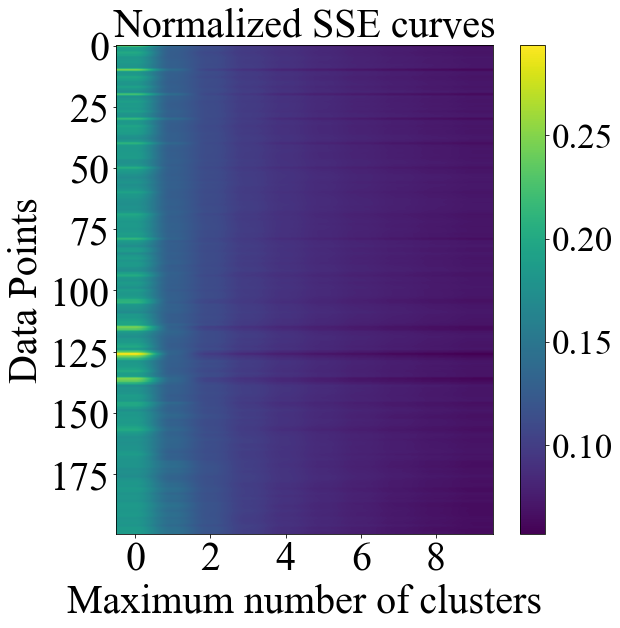

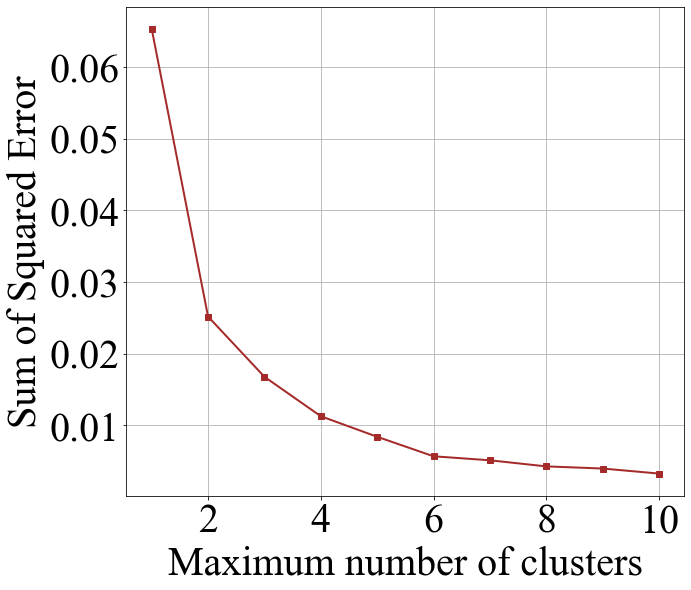

In [58]:
x_cluster = np.load(xfile)
y_cluster = np.load(yfile)
iARPESs_cluster = np.load(iARPESsfile)
ssematrix_cluster = np.load(ssefile)

fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(ssematrix_cluster, aspect = 0.065)
cbar = fig.colorbar(im)
plt.xlabel('Maximum number of clusters',fontsize=fontsize1)
plt.ylabel('Data Points',fontsize=fontsize1)
plt.title("Normalized SSE curves",fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)
cbar.ax.tick_params(labelsize=fontsize2)
plt.rcParams['font.family'] = 'Times New Roman'
fig = plt.gcf()
plt.show()
fig.savefig(f'{plotfolder}/SSEnumber.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/SSEnumber.png', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/SSEnumber.svg', dpi=300, bbox_inches='tight')



fig = get_sse_curve(max_nk,ssematrix_cluster)
fig.savefig(f'{plotfolder}/SSEplot.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/SSEplot.png', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/SSEplot.svg', dpi=300, bbox_inches='tight')

#### -  Check the second clustering result of nk=2

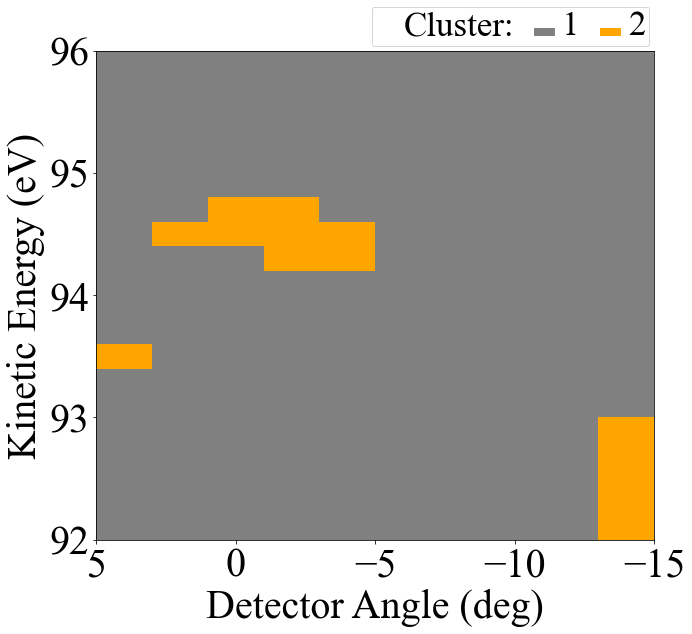

In [59]:
nk = 2
clresult_cluster,fig = get_important_field(nk, ssematrix_cluster,angstart, angend, engend, engstart,englist, anglist, label_mapping = {0:1,1:0})
fig.savefig(f'{plotfolder}/field_2.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/field_2.png', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/field_2.svg', dpi=300, bbox_inches='tight')

#### -  Check the second clustering result of nk=4

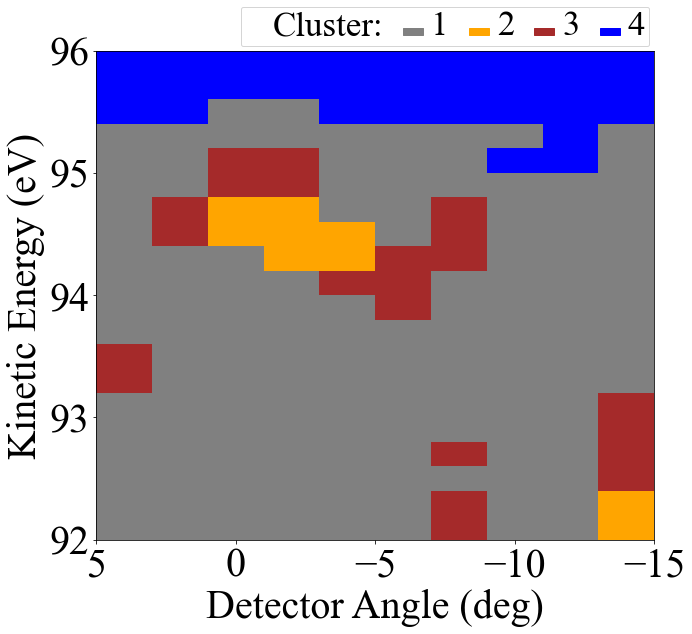

In [60]:
nk = 4
clresult_cluster,fig = get_important_field(nk, ssematrix_cluster,angstart, angend, engend, engstart,englist, anglist,label_mapping = {0:3,3:0,1:1,2:2})
fig.savefig(f'{plotfolder}/field_4.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/field_4.png', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/field_4.svg', dpi=300, bbox_inches='tight')

#### -  Check the second clustering result of nk=3

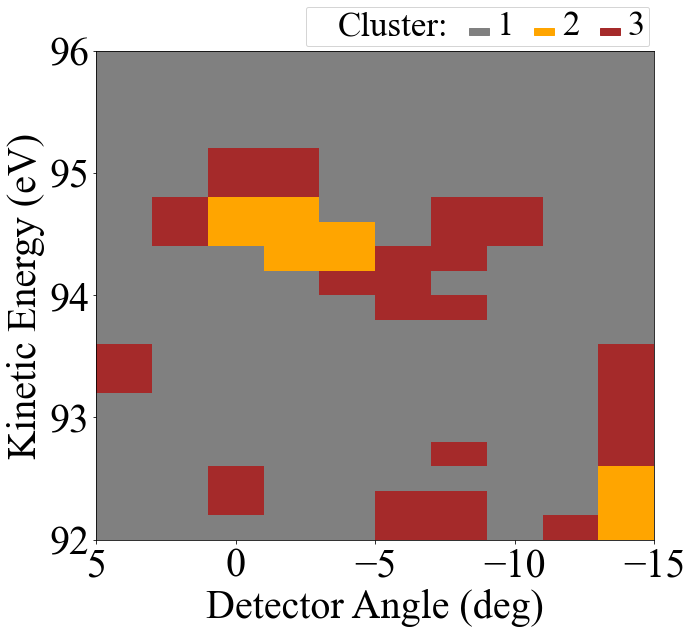

In [61]:
nk = 3
clresult_cluster,fig = get_important_field(nk, ssematrix_cluster,angstart, angend, engend, engstart,englist, anglist,label_mapping = None)
fig.savefig(f'{plotfolder}/field_3.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/field_3.png', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/field_3.svg', dpi=300, bbox_inches='tight')

### (3-iii-3) Third clustering

#### - Choose the region for third clustering (cluster2 , the orange region)
#### - show the iEDCs belonging to the region, and it is the clustering input for third clustering
#### - show the SSE of the third clustering

5 30 417 656


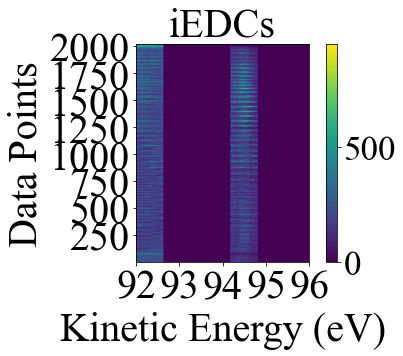

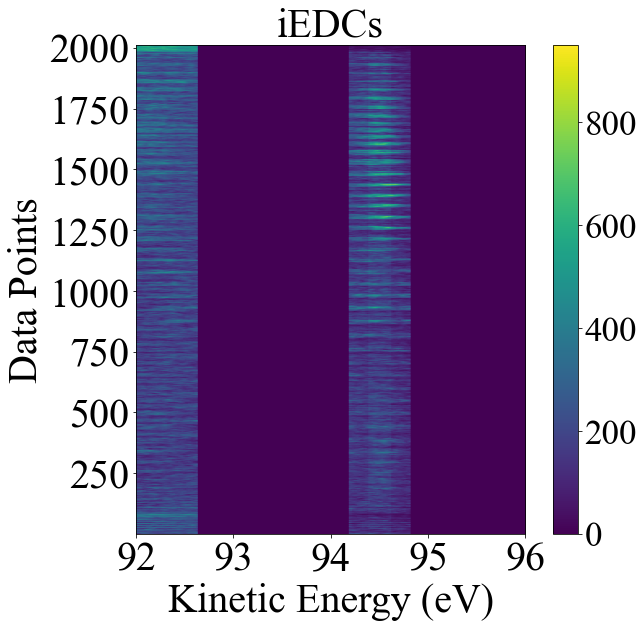

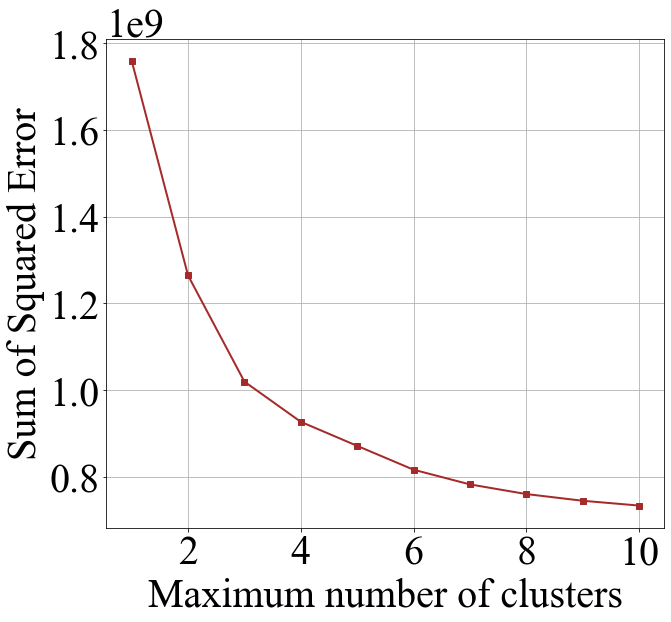

In [62]:
target = 1

iEDCs_of_target_cluster, iARPESs_of_target_cluster = get_iEDCs_of_one_field(clresult_cluster, target,angstart, angend,engstart, engend,angbin,engbin,iARPESs_cluster,ang,eng)
fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(iEDCs_of_target_cluster, extent = [engstart, engend, 1,iARPESs_of_target_cluster.shape[0]], aspect = 0.0025)
cbar = fig.colorbar(im)

plt.xlabel('Kinetic Energy (eV)',fontsize=fontsize1)
plt.ylabel('Data Points',fontsize=fontsize1)
plt.title("iEDCs",fontsize=fontsize1)
plt.xticks(np.arange(engstart, engend+1,1))
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)
cbar.ax.tick_params(labelsize=fontsize2)
plt.rcParams['font.family'] = 'Times New Roman'
fig = plt.gcf()
plt.show()
fig.savefig(f'{plotfolder}/iEDCs_n3.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/iEDCs_n3.png', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/iEDCs_n3.svg', dpi=300, bbox_inches='tight')

fig = get_sse_curve(max_nk,iEDCs_of_target_cluster)
fig.savefig(f'{plotfolder}/SSE_3.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/SSE_3.png', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/SSE_3.svg', dpi=300, bbox_inches='tight')

#### - Check the third clustering result of nk = 3
#### - Calculate performance metrics
#### - plotting

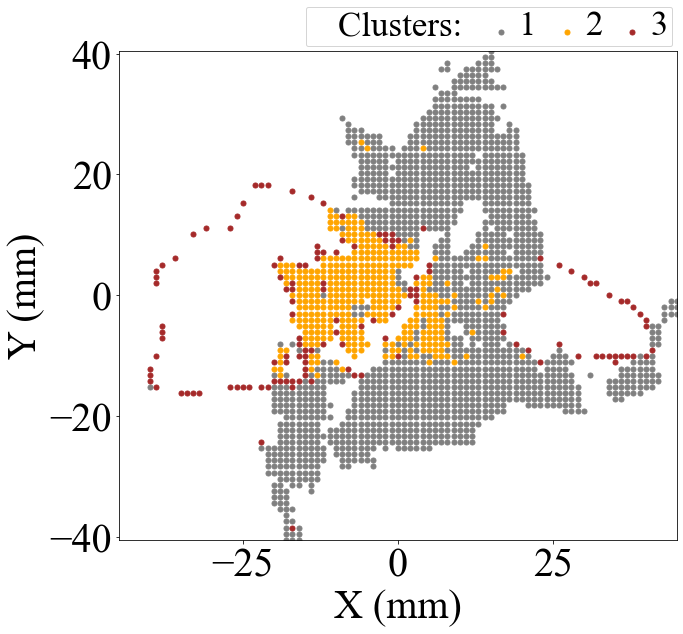

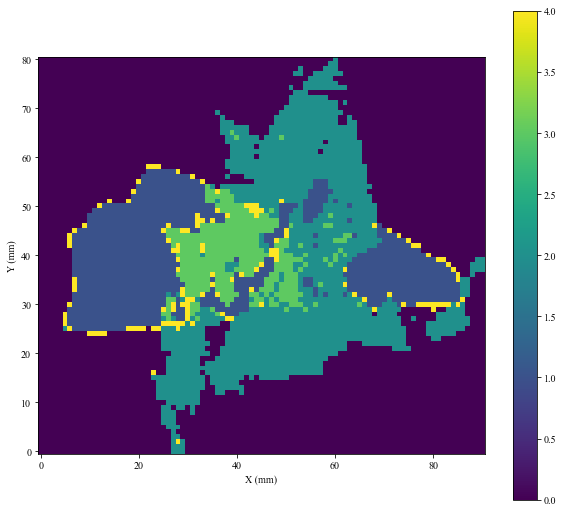

Overall Accuracy:  0.8669108669108669
Accuracy, Precision, Recall and F1 of Au:  0.9735449735449735 0.9585242896425298 0.9966642840123898 0.9772222871159911
Accuracy, Precision, Recall and F1 of BN:  0.9723239723239723 0.8380281690140845 0.9509132420091324 0.8909090909090909
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.923619590286257 0.7418712674187127 0.8653250773993808 0.7988567345480528
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.9804639804639804 0.6505376344086021 0.9453125 0.7707006369426752
Accuracy, Precision, Recall and F1 of m-MoS2:  0.9318952652285986 0.1044776119402985 0.03535353535353535 0.05283018867924528


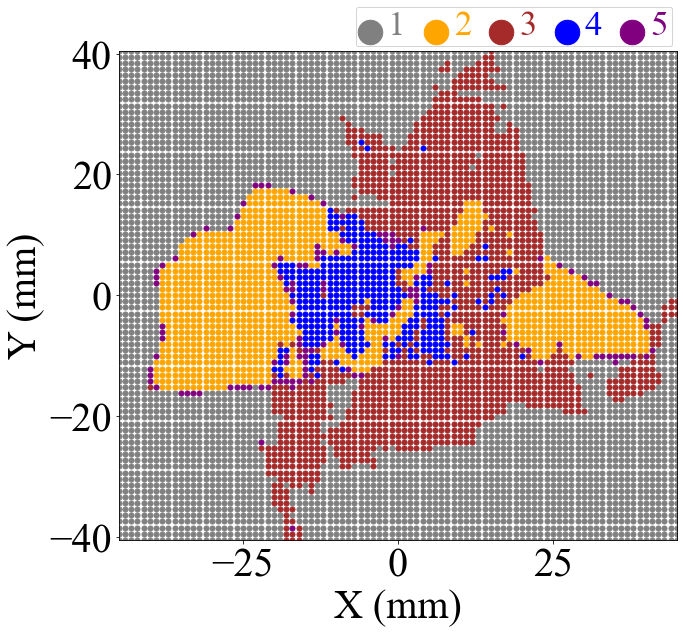

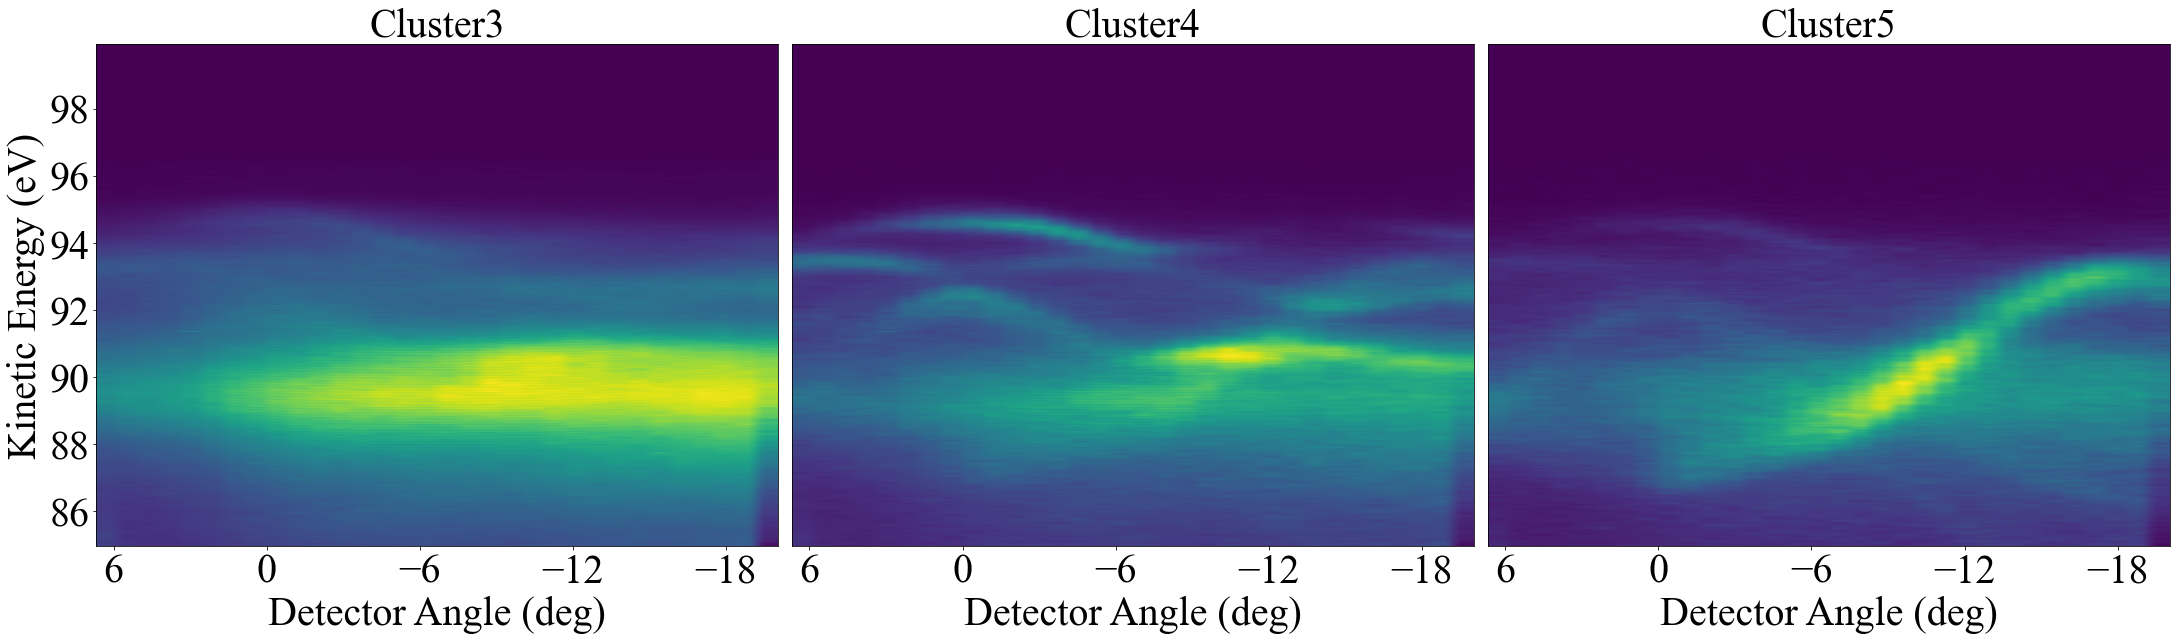

In [63]:
nk = 3
result,fig,x_list, y_list, new_km_results_of_chosen_cluster = clustering_and_visualization(nk,iEDCs_of_target_cluster,x_cluster,y_cluster,km_results_of_chosen_cluster,label_mapping={0:2, 1:0, 2:1})

label_all = np.sum([km_results_of_each_cluster[0], km_results_of_each_cluster[1], new_km_results_of_chosen_cluster[0], new_km_results_of_chosen_cluster[1], new_km_results_of_chosen_cluster[2]], axis=0)
calculate_accuracy("Accuracy of nk = 3 and momentum space of nk = 3 and engbin20 and angbin10: ", label_all, label_mapping = None)

x_of_each_cluster = [x_nk3[0], x_nk3[1], x_list[0], x_list[1], x_list[2]]
y_of_each_cluster = [y_nk3[0], y_nk3[1], y_list[0], y_list[1], y_list[2]]
fig = clustering_and_visualization_alldata(x_of_each_cluster, y_of_each_cluster)
fig.savefig(f'{plotfolder}/plot_3-3.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/plot_3-3.png', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/plot_3-3.svg', dpi=300, bbox_inches='tight')

fig = iARPESs_cluster_visualization(nk,result,iARPESs_cluster,ang_ini,ang_end,eng_ini,eng_end)
fig.savefig(f'{plotfolder}/ARPES_3-3.pdf', dpi=300)
fig.savefig(f'{plotfolder}/ARPES_3-3.png', dpi=300)
fig.savefig(f'{plotfolder}/ARPES_3-3.svg', dpi=300)

#### - Check the third clustering result of nk = 4
#### - Calculate performance metrics
#### - plotting

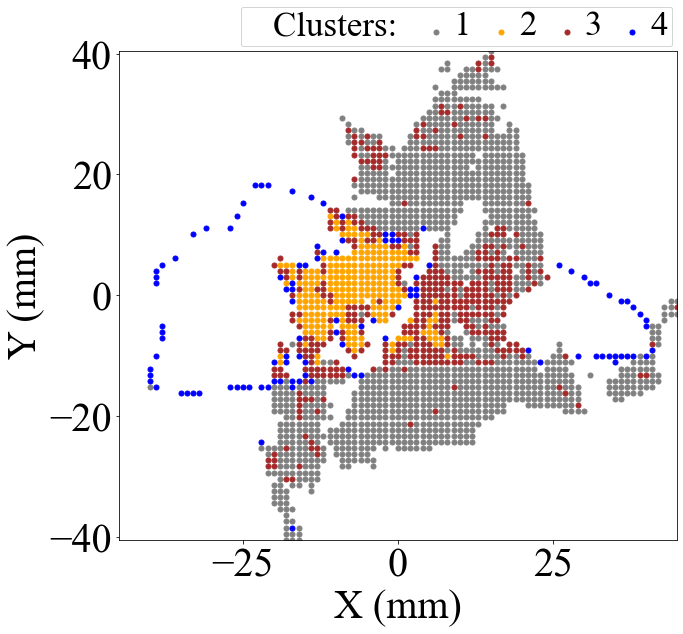

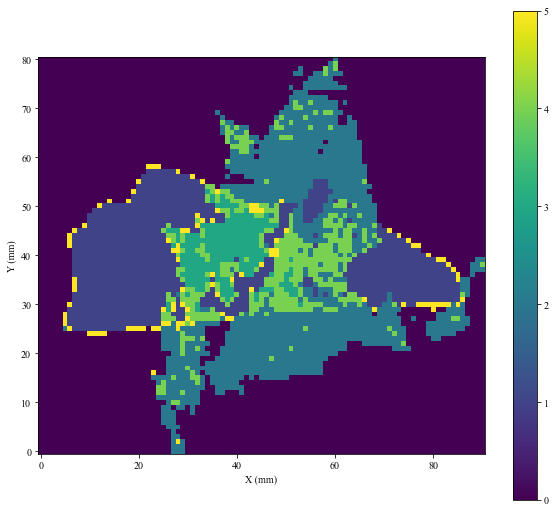

Overall Accuracy:  0.875322208655542
Accuracy, Precision, Recall and F1 of Au:  0.9735449735449735 0.9585242896425298 0.9966642840123898 0.9772222871159911
Accuracy, Precision, Recall and F1 of BN:  0.9723239723239723 0.8380281690140845 0.9509132420091324 0.8909090909090909
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.9314882648215982 0.812549642573471 0.791795665634675 0.8020384163073304
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.9891466558133225 0.8859649122807017 0.7890625 0.834710743801653
Accuracy, Precision, Recall and F1 of m-MoS2:  0.9469542802876136 0.5059952038369304 0.5328282828282829 0.5190651906519065


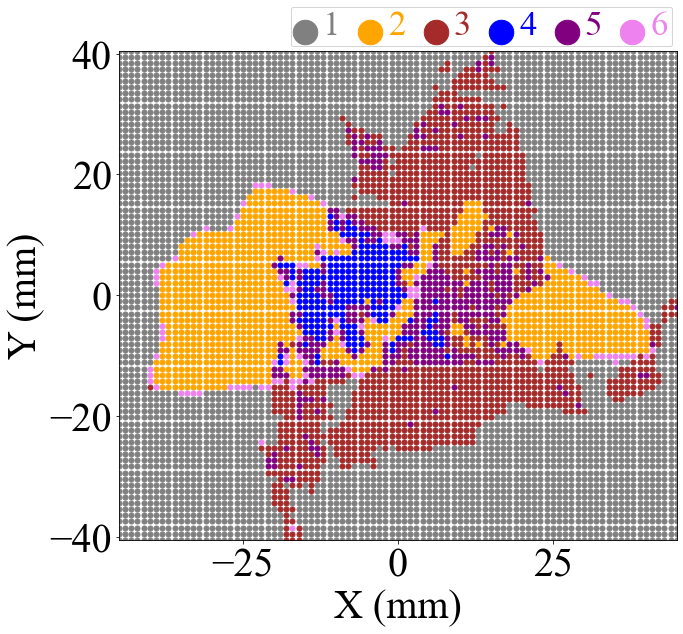

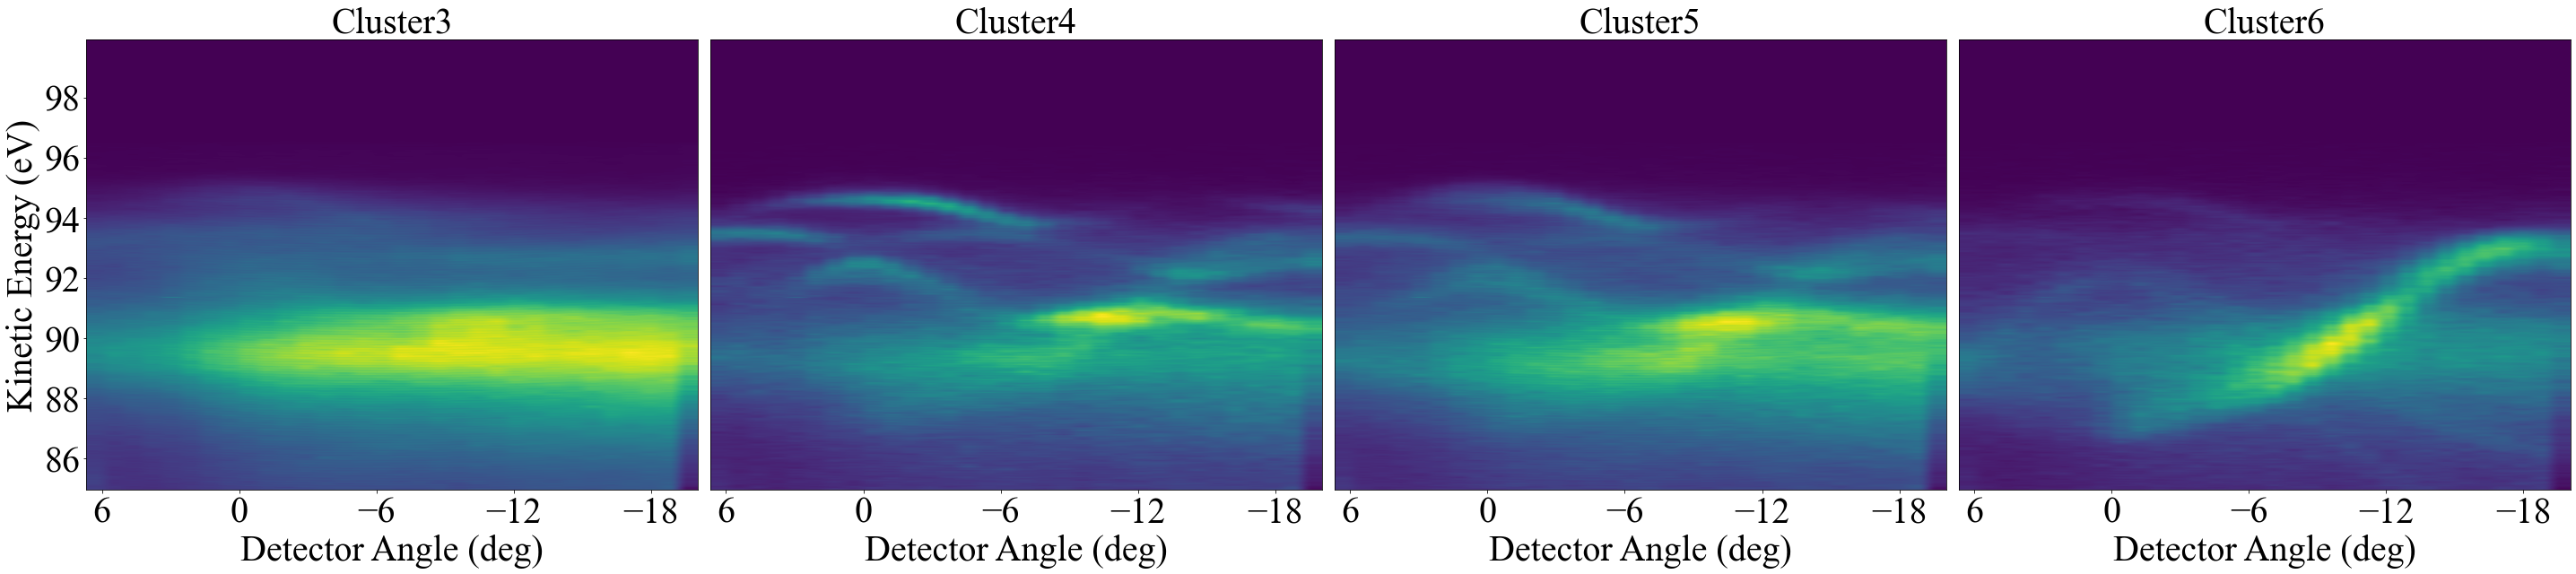

17 30 536 656
(4, 121, 14) (2013, 889, 32)


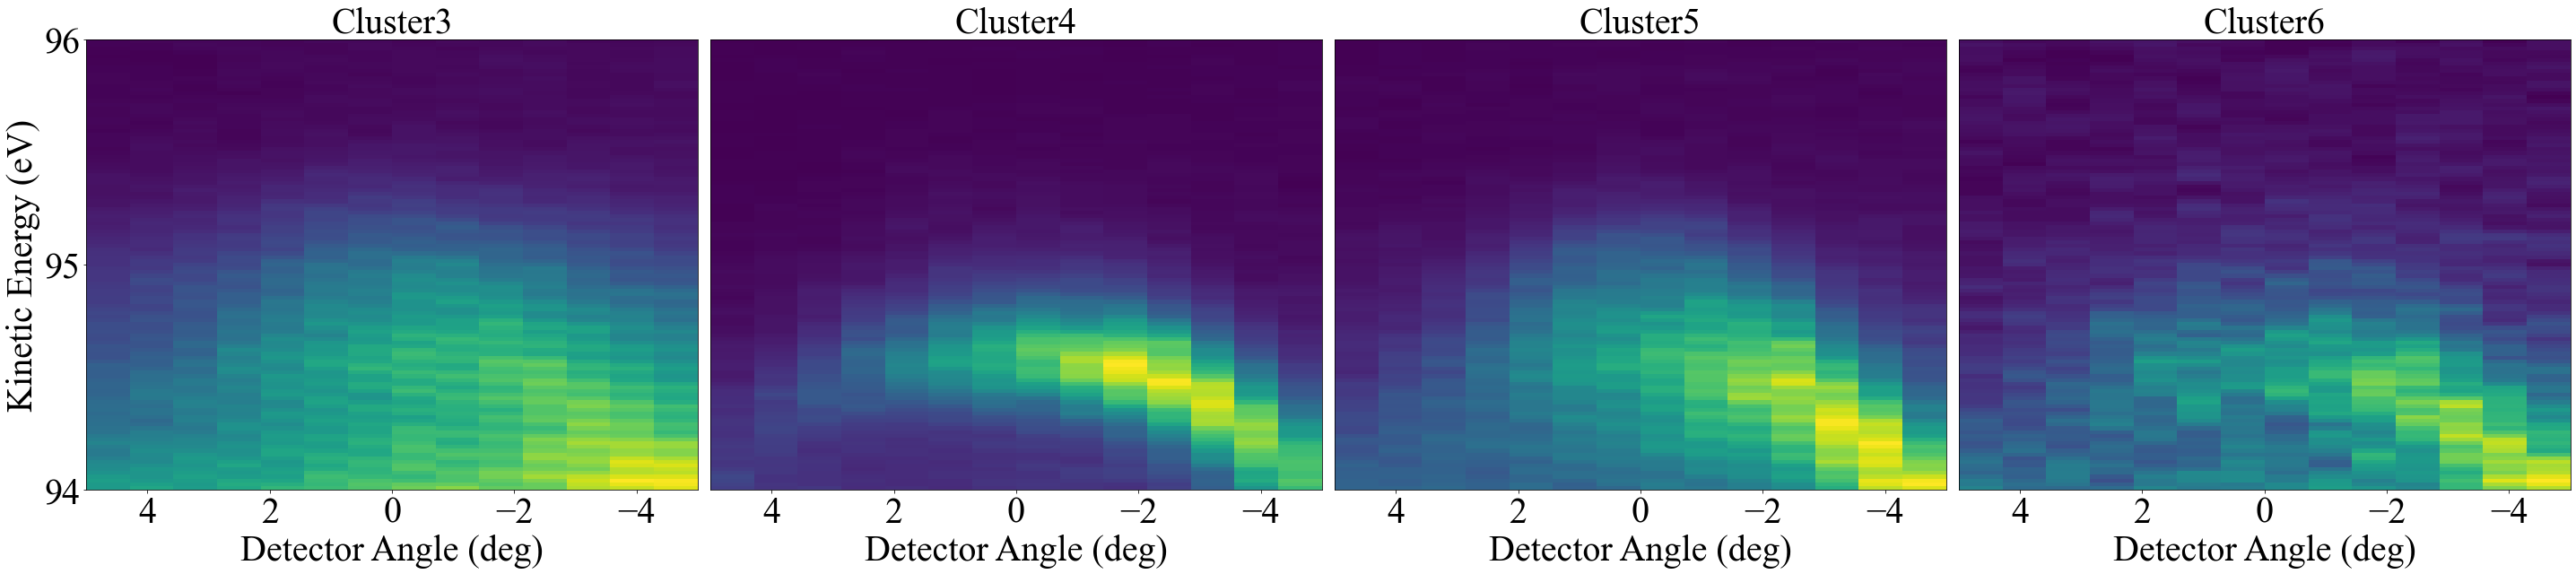

In [64]:
nk = 4
result,fig,x_list, y_list, new_km_results_of_chosen_cluster = clustering_and_visualization(nk,iEDCs_of_target_cluster,x_cluster,y_cluster,km_results_of_chosen_cluster,label_mapping={0:0, 3:1, 2:2, 1:3})

### only suitable for cluster_chosen = 2
label_all = np.sum([km_results_of_each_cluster[0], km_results_of_each_cluster[1], new_km_results_of_chosen_cluster[0], new_km_results_of_chosen_cluster[1], new_km_results_of_chosen_cluster[2], new_km_results_of_chosen_cluster[3]], axis=0)
calculate_accuracy("Accuracy of nk = 4 and momentum space of nk = 3 and engbin20 and angbin10: ", label_all, label_mapping = None)

x_of_each_cluster = [x_nk3[0], x_nk3[1], x_list[0], x_list[1], x_list[2], x_list[3]]
y_of_each_cluster = [y_nk3[0], y_nk3[1], y_list[0], y_list[1], y_list[2], y_list[3]]
fig = clustering_and_visualization_alldata(x_of_each_cluster, y_of_each_cluster)
fig.savefig(f'{plotfolder}/plot_3-4.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/plot_3-4.png', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/plot_3-4.svg', dpi=300, bbox_inches='tight')

fig = iARPESs_cluster_visualization(nk,result,iARPESs_cluster,ang_ini,ang_end,eng_ini,eng_end)
fig.savefig(f'{plotfolder}/ARPES_3-4.pdf', dpi=300)
fig.savefig(f'{plotfolder}/ARPES_3-4.png', dpi=300)
fig.savefig(f'{plotfolder}/ARPES_3-4.svg', dpi=300)
fig = iARPESs_cluster_visualization_selfdefined_range(nk,result,iARPESs_cluster,-5,5,94,96,ang,eng)
fig.savefig(f'{plotfolder}/ARPES_3-4_topvalence.pdf', dpi=300)
fig.savefig(f'{plotfolder}/ARPES_3-4_topvalence.png', dpi=300)
fig.savefig(f'{plotfolder}/ARPES_3-4_topvalence.svg', dpi=300)

# Part 4: Dependence of cells on the result 

## (4-i) 800 cells case

In [65]:
# perform high-order unsupervised clustering based on the above K-means clustering of nk=3 case
coarseclustering_chosen = 3
fineclusteringfile = f'kmresults_{coarseclustering_chosen}.npy'
if not os.path.exists(fineclusteringfile):
    print(f"File {fineclusteringfile} does not exist")
else:
    print(f"File {fineclusteringfile} exist")   
results = np.load(fineclusteringfile)

# perform high-order unsupervised clustering based ARPES images of cluster 2 (MoS2)
cluster_chosen = 3
# Analysis range from Ek 92 to 96eV and angle -15 to 5deg.
engstart = 92
engend = 96
angstart = -15
angend = 5
# divide the analysis range into 800 cells (40 intervals in Ek direction and 20 intervals in angle direction)
engbin = 40
angbin = 20

# Get the minimum value of energy and angle of each interval
k=0
englist=np.zeros(engbin*angbin)
anglist=np.zeros(engbin*angbin)
for i in range(engbin):
    for j in range(angbin):
        anglist[k] = angstart+(angend-angstart)/angbin*j
        englist[k] = engstart+(engend-engstart)/engbin*i
        k += 1
#print(englist)
#print(anglist)

# SSE curve includes 10 SSE values
max_nk = 10

folder = f'results_fineclustering_{coarseclustering_chosen}'
if not os.path.exists(folder):
    print(f"{folder} does not exist")
    os.makedirs(folder)
    
plotfolder = f'{folder}/plot_cluster{cluster_chosen}_eng{engstart}_{engend}_ang{angstart}_{angend}_engbin{engbin}_angbin{angbin}'
if not os.path.exists(plotfolder):
    print(f"{plotfolder} does not exist")
    os.makedirs(plotfolder)

File kmresults_3.npy exist


In [66]:
t1 = time.time() 

xfile = f'{folder}/x_cluster{cluster_chosen}_eng{engstart}_{engend}_ang{angstart}_{angend}_engbin{engbin}_angbin{angbin}.npy'
yfile = f'{folder}/y_cluster{cluster_chosen}_eng{engstart}_{engend}_ang{angstart}_{angend}_engbin{engbin}_angbin{angbin}.npy'
iARPESsfile = f'{folder}/iARPESs_cluster{cluster_chosen}_eng{engstart}_{engend}_ang{angstart}_{angend}_engbin{engbin}_angbin{angbin}.npy'
ssefile = f'{folder}/ssematrix_cluster{cluster_chosen}_eng{engstart}_{engend}_ang{angstart}_{angend}_engbin{engbin}_angbin{angbin}.npy'

file_paths = [xfile, yfile, iARPESsfile, ssefile]  

all_files_exist = True

for file_path in file_paths:
    if not os.path.exists(file_path):
        print(f"File {file_path} does not exist")
        all_files_exist = False

if all_files_exist:
    print("All Files exist")
else:
    print("Some files do not exist, execute the following command")
    # Get the position in real space(x,y), ARPES images of cluster 2(cluster_chosen) based on the traditional K-means result(result)
    # Get the clustering result(SSE curve) based on the area(engstart, engend,angstart, angend) and intervals(engbin,angbin)
    x_cluster, y_cluster, iARPESs_cluster,ssematrix_cluster = get_realspace_location_and_iARPESs_and_ssematrix_of_one_cluster(results,cluster_chosen,engstart, engend,angstart, angend,engbin,angbin,max_nk)
    np.save(xfile, x_cluster)
    np.save(yfile, y_cluster)
    np.save(iARPESsfile, iARPESs_cluster)
    np.save(ssefile, ssematrix_cluster)

t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)

All Files exist
Elapsed Time:  0.0010747909545898438


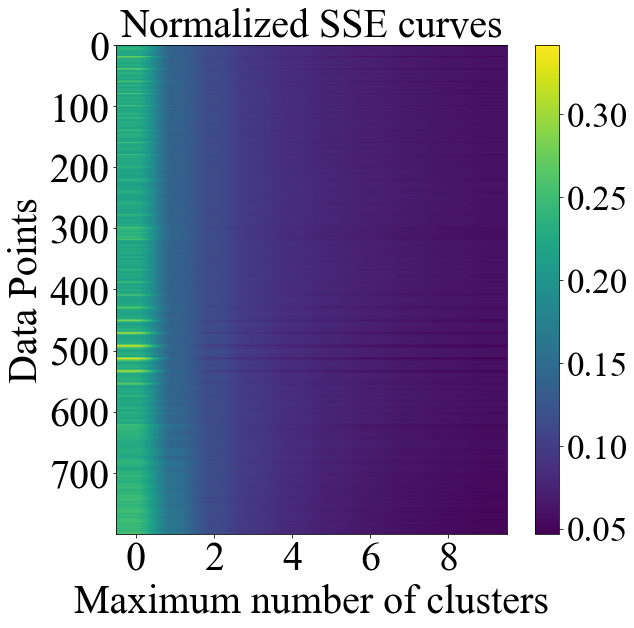

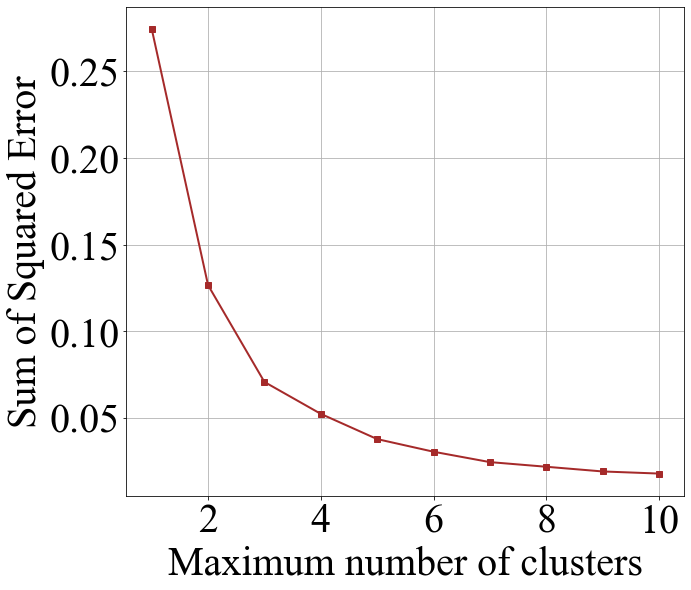

In [67]:
x_cluster = np.load(xfile)
y_cluster = np.load(yfile)
iARPESs_cluster = np.load(iARPESsfile)
ssematrix_cluster = np.load(ssefile)

fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(ssematrix_cluster, aspect = 0.01565)
cbar = fig.colorbar(im)
plt.xlabel('Maximum number of clusters',fontsize=fontsize1)
plt.ylabel('Data Points',fontsize=fontsize1)
plt.title("Normalized SSE curves",fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)
cbar.ax.tick_params(labelsize=fontsize2)
plt.rcParams['font.family'] = 'Times New Roman'
fig = plt.gcf()
plt.show()
fig.savefig(f'{plotfolder}/SSEnumber_800.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/SSEnumber_800.png', dpi=300, bbox_inches='tight')

#print(x_cluster)
fig = get_sse_curve(max_nk,ssematrix_cluster)
fig.savefig(f'{plotfolder}/SSEplot.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/SSEplot.png', dpi=300, bbox_inches='tight')

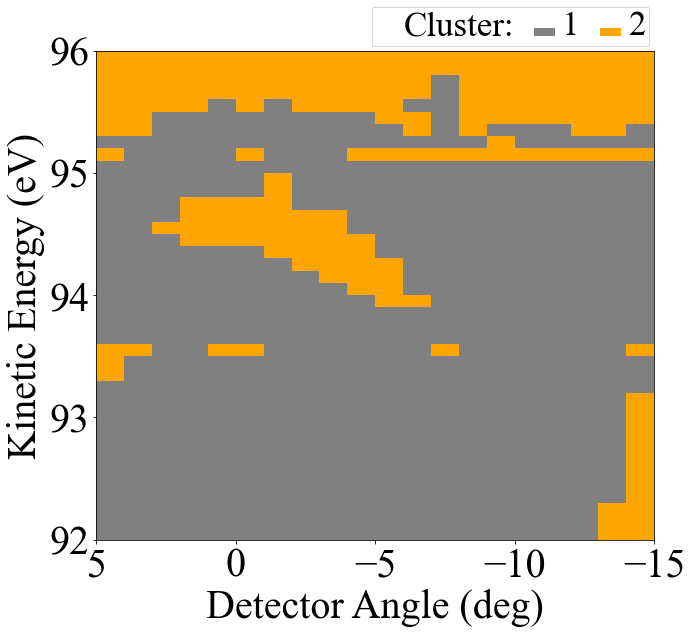

In [68]:
nk = 2
clresult_cluster,fig = get_important_field(nk, ssematrix_cluster,angstart, angend, engend, engstart,englist, anglist,label_mapping = None)
fig.savefig(f'{plotfolder}/field_2.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/field_2.png', dpi=300, bbox_inches='tight')

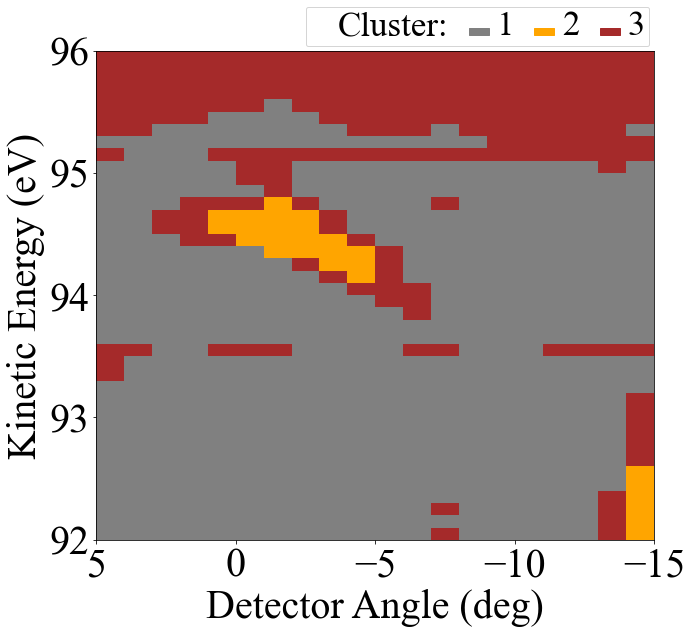

In [69]:
nk = 3
clresult_cluster,fig = get_important_field(nk, ssematrix_cluster,angstart, angend, engend, engstart,englist, anglist,label_mapping = {2:1,1:2,0:0})
fig.savefig(f'{plotfolder}/field_3.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/field_3.png', dpi=300, bbox_inches='tight')

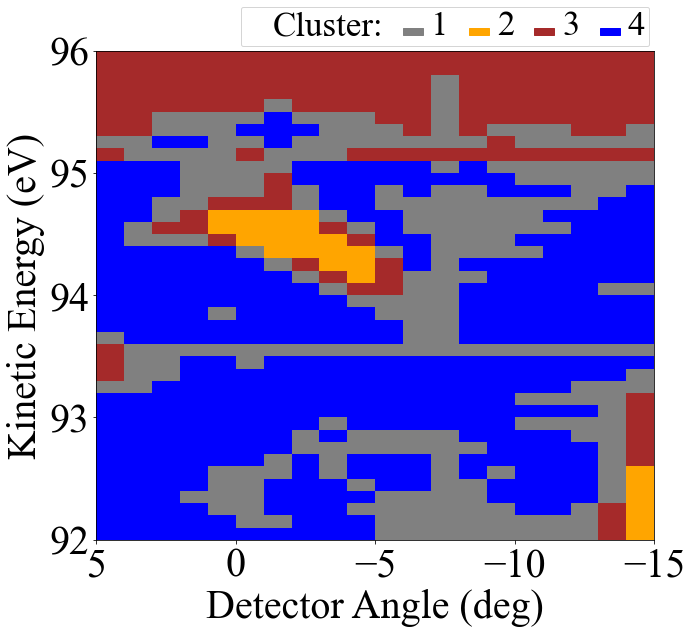

In [70]:
nk = 4
clresult_cluster,fig = get_important_field(nk, ssematrix_cluster,angstart, angend, engend, engstart,englist, anglist,label_mapping = {2:1,1:2,3:0,0:3})
fig.savefig(f'{plotfolder}/field_4.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/field_4.png', dpi=300, bbox_inches='tight')

## (4-ii) 1600 cells case

In [71]:
# perform high-order unsupervised clustering based on the above K-means clustering of nk=3 case
coarseclustering_chosen = 3
fineclusteringfile = f'kmresults_{coarseclustering_chosen}.npy'
if not os.path.exists(fineclusteringfile):
    print(f"File {fineclusteringfile} does not exist")
else:
    print(f"File {fineclusteringfile} exist")   
results = np.load(fineclusteringfile)

# perform high-order unsupervised clustering based ARPES images of cluster 2 (MoS2)
cluster_chosen = 3
# Analysis range from Ek 92 to 96eV and angle -15 to 5deg.
engstart = 92
engend = 96
angstart = -15
angend = 5
# divide the analysis range into 1600 cells (40 intervals in Ek direction and 40 intervals in angle direction)
engbin = 40
angbin = 40

# Get the minimum value of energy and angle of each interval
k=0
englist=np.zeros(engbin*angbin)
anglist=np.zeros(engbin*angbin)
for i in range(engbin):
    for j in range(angbin):
        anglist[k] = angstart+(angend-angstart)/angbin*j
        englist[k] = engstart+(engend-engstart)/engbin*i
        k += 1
#print(englist)
#print(anglist)

# SSE curve includes 10 SSE values
max_nk = 10

folder = f'results_fineclustering_{coarseclustering_chosen}'
if not os.path.exists(folder):
    print(f"{folder} does not exist")
    os.makedirs(folder)
    
plotfolder = f'{folder}/plot_cluster{cluster_chosen}_eng{engstart}_{engend}_ang{angstart}_{angend}_engbin{engbin}_angbin{angbin}'
if not os.path.exists(plotfolder):
    print(f"{plotfolder} does not exist")
    os.makedirs(plotfolder)

File kmresults_3.npy exist


In [72]:
t1 = time.time() 

xfile = f'{folder}/x_cluster{cluster_chosen}_eng{engstart}_{engend}_ang{angstart}_{angend}_engbin{engbin}_angbin{angbin}.npy'
yfile = f'{folder}/y_cluster{cluster_chosen}_eng{engstart}_{engend}_ang{angstart}_{angend}_engbin{engbin}_angbin{angbin}.npy'
iARPESsfile = f'{folder}/iARPESs_cluster{cluster_chosen}_eng{engstart}_{engend}_ang{angstart}_{angend}_engbin{engbin}_angbin{angbin}.npy'
ssefile = f'{folder}/ssematrix_cluster{cluster_chosen}_eng{engstart}_{engend}_ang{angstart}_{angend}_engbin{engbin}_angbin{angbin}.npy'

file_paths = [xfile, yfile, iARPESsfile, ssefile]  

all_files_exist = True

for file_path in file_paths:
    if not os.path.exists(file_path):
        print(f"File {file_path} does not exist")
        all_files_exist = False

if all_files_exist:
    print("All Files exist")
else:
    print("Some files do not exist, execute the following command")
    # Get the position in real space(x,y), ARPES images of cluster 2(cluster_chosen) based on the traditional K-means result(result)
    # Get the clustering result(SSE curve) based on the area(engstart, engend,angstart, angend) and intervals(engbin,angbin)
    x_cluster, y_cluster, iARPESs_cluster,ssematrix_cluster = get_realspace_location_and_iARPESs_and_ssematrix_of_one_cluster(results,cluster_chosen,engstart, engend,angstart, angend,engbin,angbin,max_nk)
    np.save(xfile, x_cluster)
    np.save(yfile, y_cluster)
    np.save(iARPESsfile, iARPESs_cluster)
    np.save(ssefile, ssematrix_cluster)

t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)

All Files exist
Elapsed Time:  0.0009927749633789062


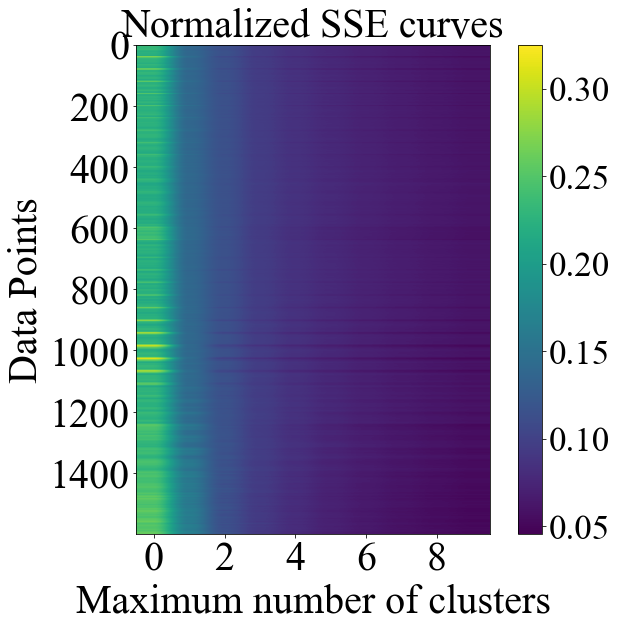

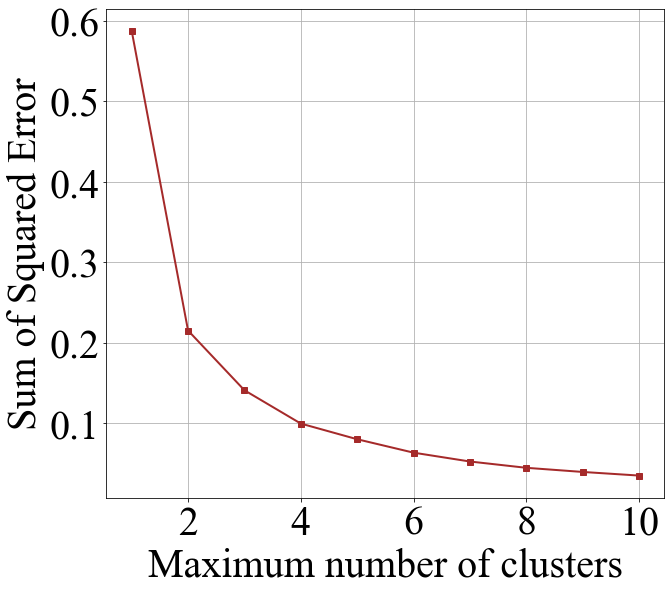

In [73]:
x_cluster = np.load(xfile)
y_cluster = np.load(yfile)
iARPESs_cluster = np.load(iARPESsfile)
ssematrix_cluster = np.load(ssefile)

fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(ssematrix_cluster, aspect = 0.00865)
cbar = fig.colorbar(im)
plt.xlabel('Maximum number of clusters',fontsize=fontsize1)
plt.ylabel('Data Points',fontsize=fontsize1)
plt.title("Normalized SSE curves",fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)
cbar.ax.tick_params(labelsize=fontsize2)
plt.rcParams['font.family'] = 'Times New Roman'
fig = plt.gcf()
plt.show()
fig.savefig(f'{plotfolder}/SSEnumber_1600.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/SSEnumber_1600.png', dpi=300, bbox_inches='tight')

fig = get_sse_curve(max_nk,ssematrix_cluster)
fig.savefig(f'{plotfolder}/SSEplot.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/SSEplot.png', dpi=300, bbox_inches='tight')

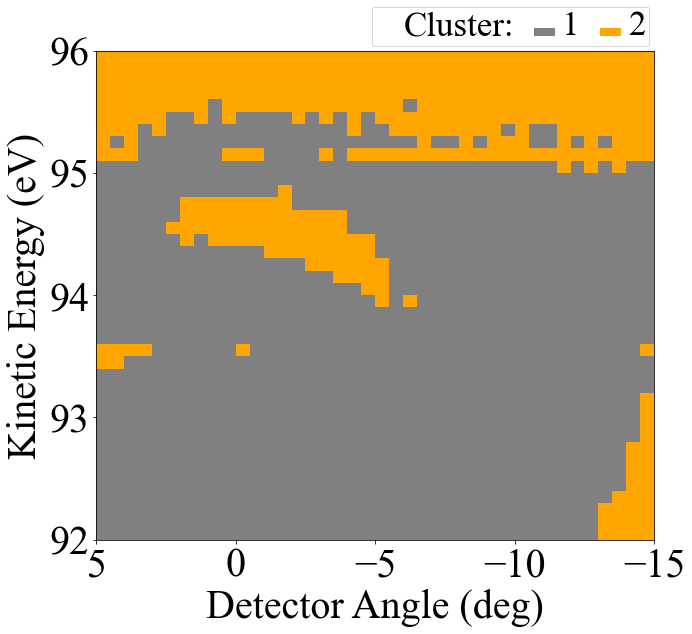

In [74]:
nk = 2
clresult_cluster,fig = get_important_field(nk, ssematrix_cluster,angstart, angend, engend, engstart,englist, anglist,label_mapping = {0:1,1:0})
fig.savefig(f'{plotfolder}/field_2.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/field_2.png', dpi=300, bbox_inches='tight')

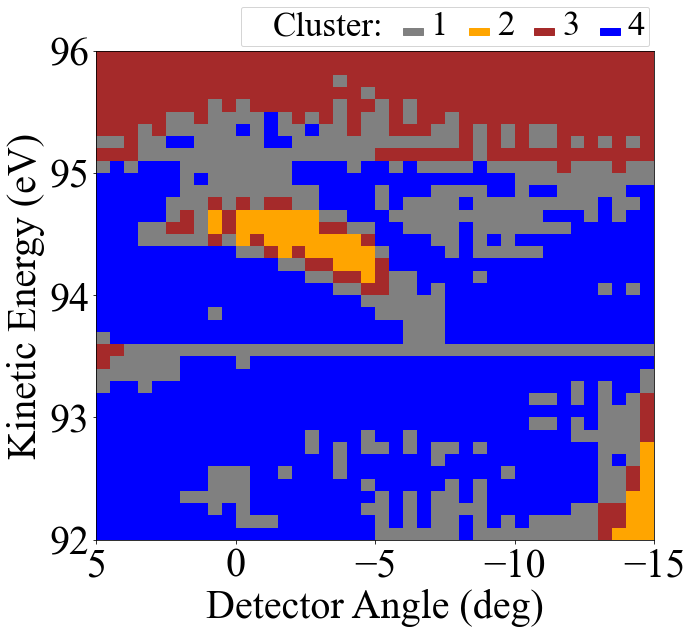

In [75]:
nk = 4
clresult_cluster,fig = get_important_field(nk, ssematrix_cluster,angstart, angend, engend, engstart,englist, anglist,label_mapping = {1:2,3:1,2:0,0:3})
fig.savefig(f'{plotfolder}/field_4.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/field_4.png', dpi=300, bbox_inches='tight')

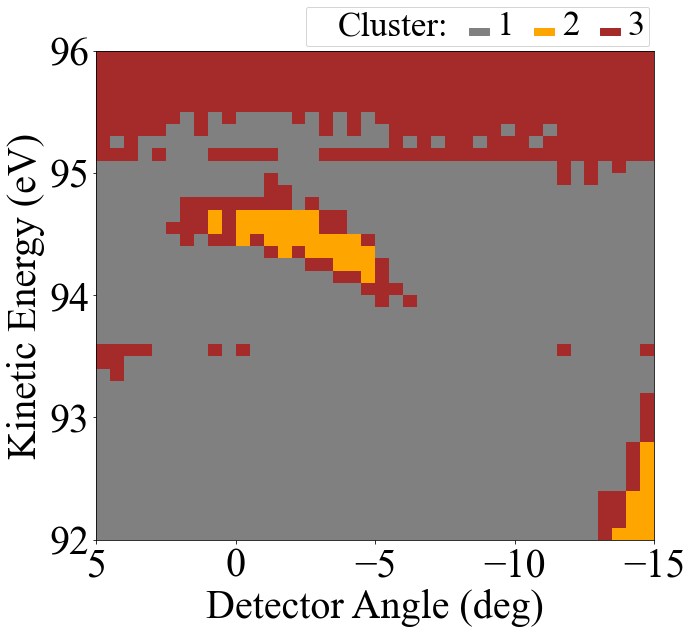

In [76]:
nk = 3
clresult_cluster,fig = get_important_field(nk, ssematrix_cluster,angstart, angend, engend, engstart,englist, anglist,label_mapping = {1:0,0:1,2:2})
fig.savefig(f'{plotfolder}/field_3.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/field_3.png', dpi=300, bbox_inches='tight')

5 30 417 656


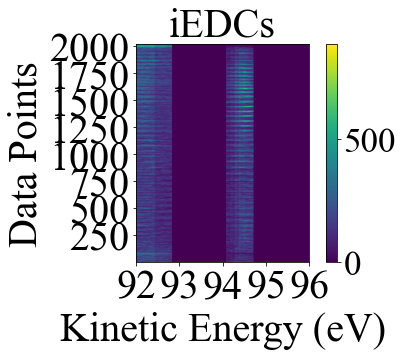

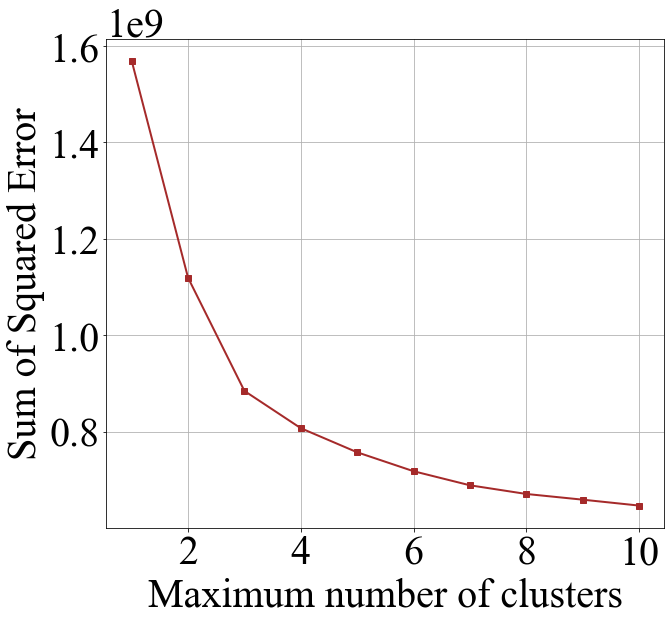

In [77]:
target = 1

iEDCs_of_target_cluster, iARPESs_of_target_cluster = get_iEDCs_of_one_field(clresult_cluster, target,angstart, angend,engstart, engend,angbin,engbin,iARPESs_cluster,ang,eng)
fig = get_sse_curve(max_nk,iEDCs_of_target_cluster)
fig.savefig(f'{plotfolder}/SSE_3.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/SSE_3.png', dpi=300, bbox_inches='tight')

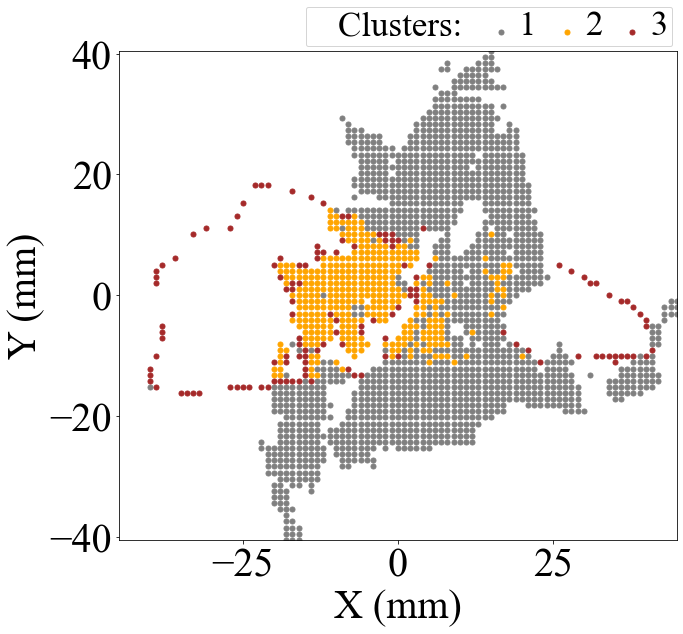

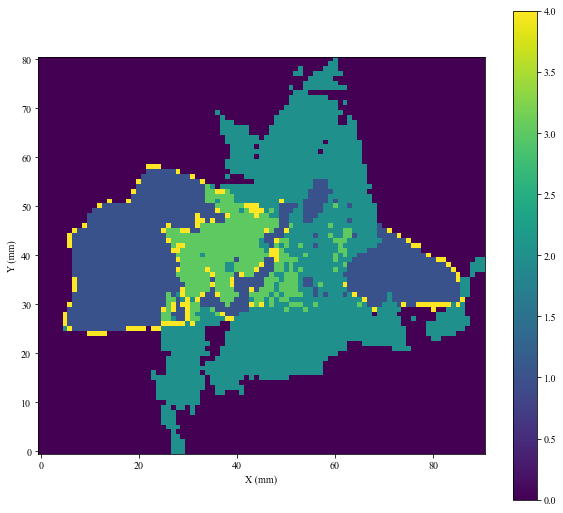

Overall Accuracy:  0.8670465337132004
Accuracy, Precision, Recall and F1 of Au:  0.9735449735449735 0.9585242896425298 0.9966642840123898 0.9772222871159911
Accuracy, Precision, Recall and F1 of BN:  0.9723239723239723 0.8380281690140845 0.9509132420091324 0.8909090909090909
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.9230769230769231 0.7386438446346281 0.868421052631579 0.7982924226254002
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.9816849816849816 0.6666666666666666 0.9453125 0.7819063004846526
Accuracy, Precision, Recall and F1 of m-MoS2:  0.9314882648215982 0.08396946564885496 0.027777777777777776 0.04174573055028463


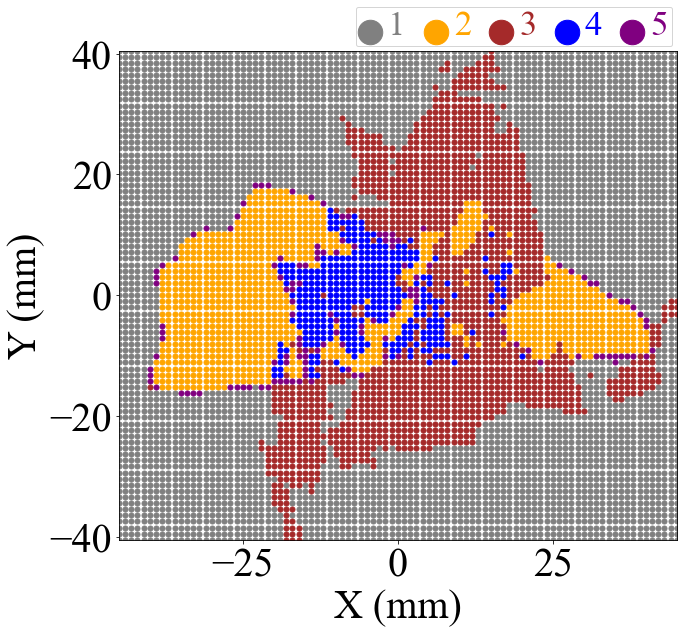

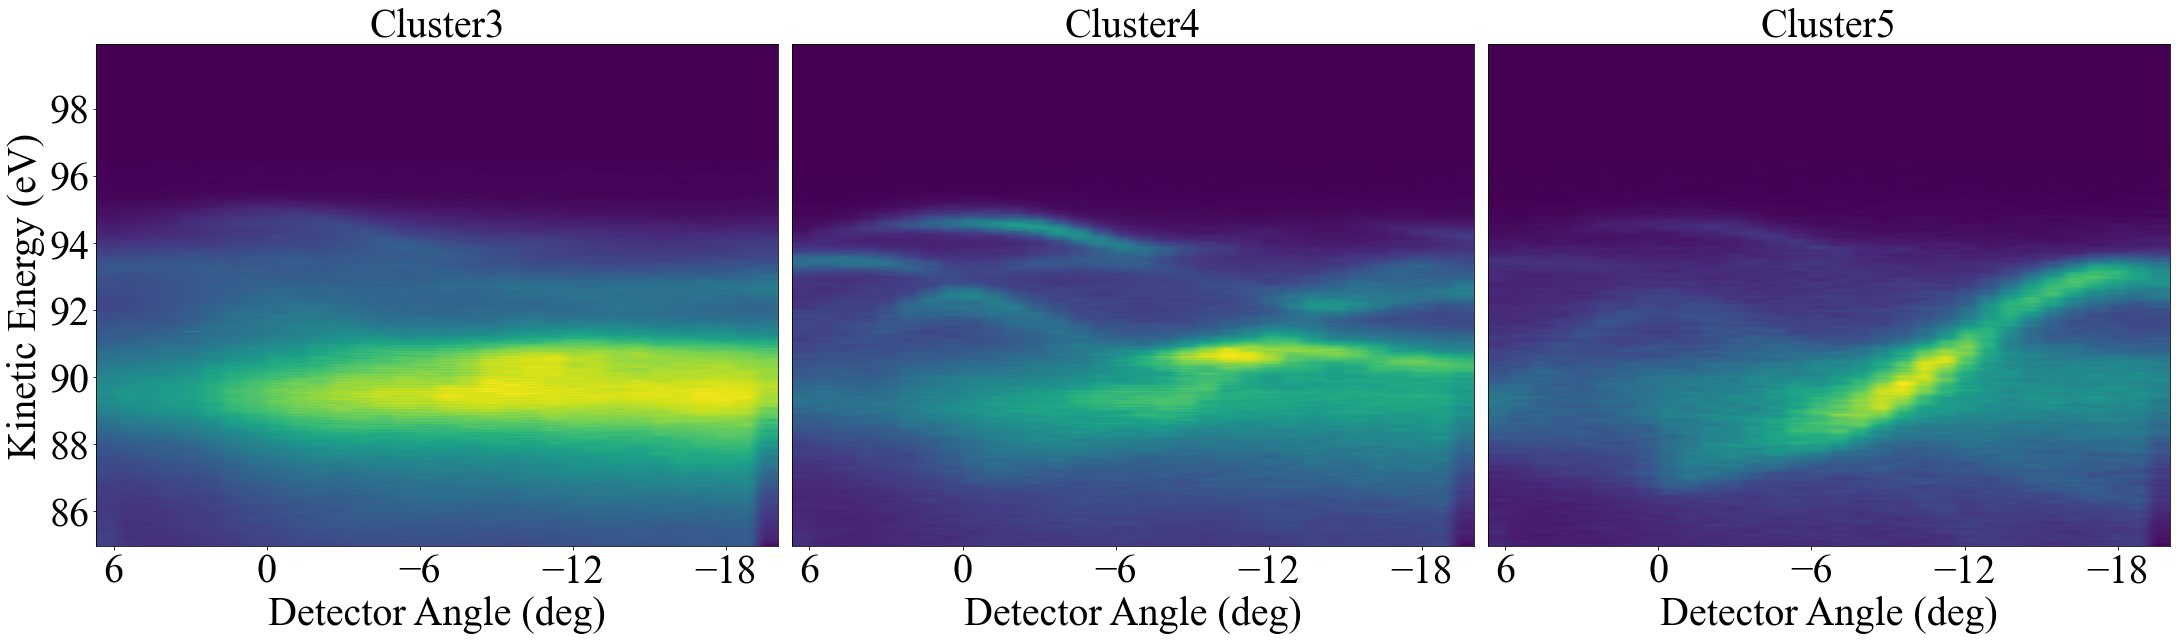

In [78]:
nk = 3
result,fig,x_list, y_list, new_km_results_of_chosen_cluster = clustering_and_visualization(nk,iEDCs_of_target_cluster,x_cluster,y_cluster,km_results_of_chosen_cluster,label_mapping=None)

label_all = np.sum([km_results_of_each_cluster[0], km_results_of_each_cluster[1], new_km_results_of_chosen_cluster[0], new_km_results_of_chosen_cluster[1], new_km_results_of_chosen_cluster[2]], axis=0)
calculate_accuracy("Accuracy of nk = 3 and momentum space of nk = 3 and engbin40 and angbin40: ", label_all, label_mapping = None)

x_of_each_cluster = [x_nk3[0], x_nk3[1], x_list[0], x_list[1], x_list[2]]
y_of_each_cluster = [y_nk3[0], y_nk3[1], y_list[0], y_list[1], y_list[2]]
fig = clustering_and_visualization_alldata(x_of_each_cluster, y_of_each_cluster)
fig.savefig(f'{plotfolder}/plot_3-3.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/plot_3-3.png', dpi=300, bbox_inches='tight')

fig = iARPESs_cluster_visualization(nk,result,iARPESs_cluster,ang_ini,ang_end,eng_ini,eng_end)
fig.savefig(f'{plotfolder}/ARPES_3-3.pdf', dpi=300)
fig.savefig(f'{plotfolder}/ARPES_3-3.png', dpi=300)

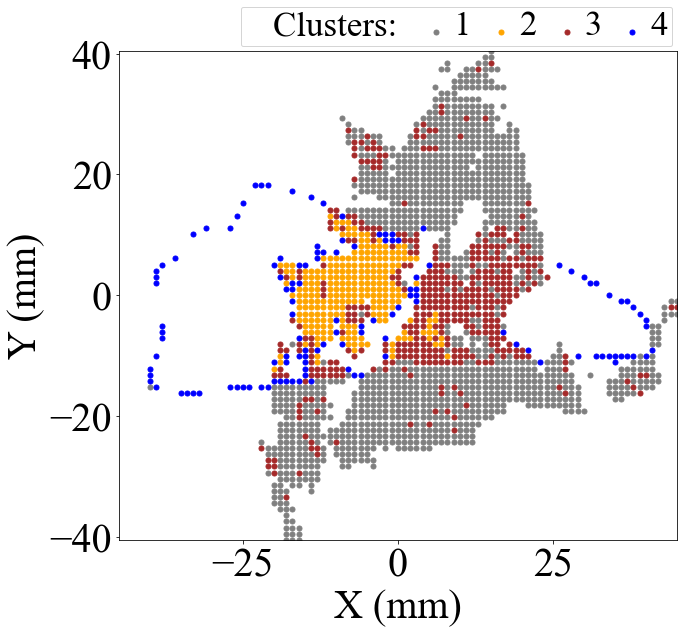

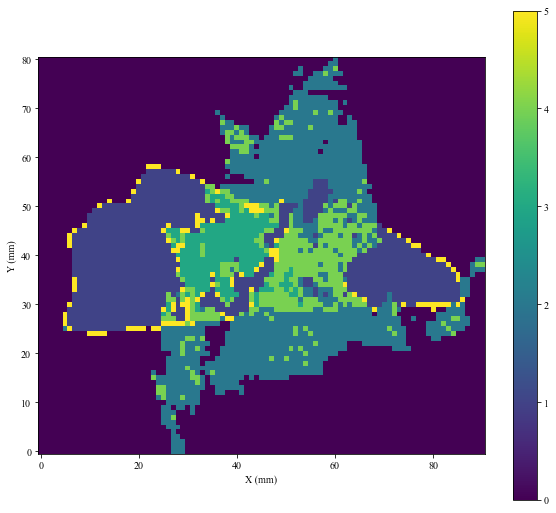

Overall Accuracy:  0.8814272147605481
Accuracy, Precision, Recall and F1 of Au:  0.9735449735449735 0.9585242896425298 0.9966642840123898 0.9772222871159911
Accuracy, Precision, Recall and F1 of BN:  0.9723239723239723 0.8380281690140845 0.9509132420091324 0.8909090909090909
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.9373219373219374 0.841845140032949 0.7910216718266254 0.8156424581005588
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.9905033238366572 0.8780487804878049 0.84375 0.8605577689243028
Accuracy, Precision, Recall and F1 of m-MoS2:  0.9541446208112875 0.5677570093457944 0.6136363636363636 0.5898058252427185


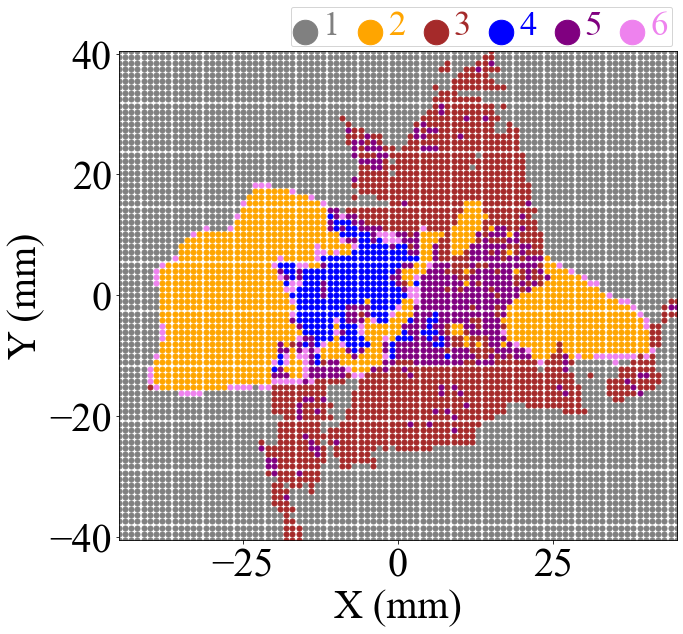

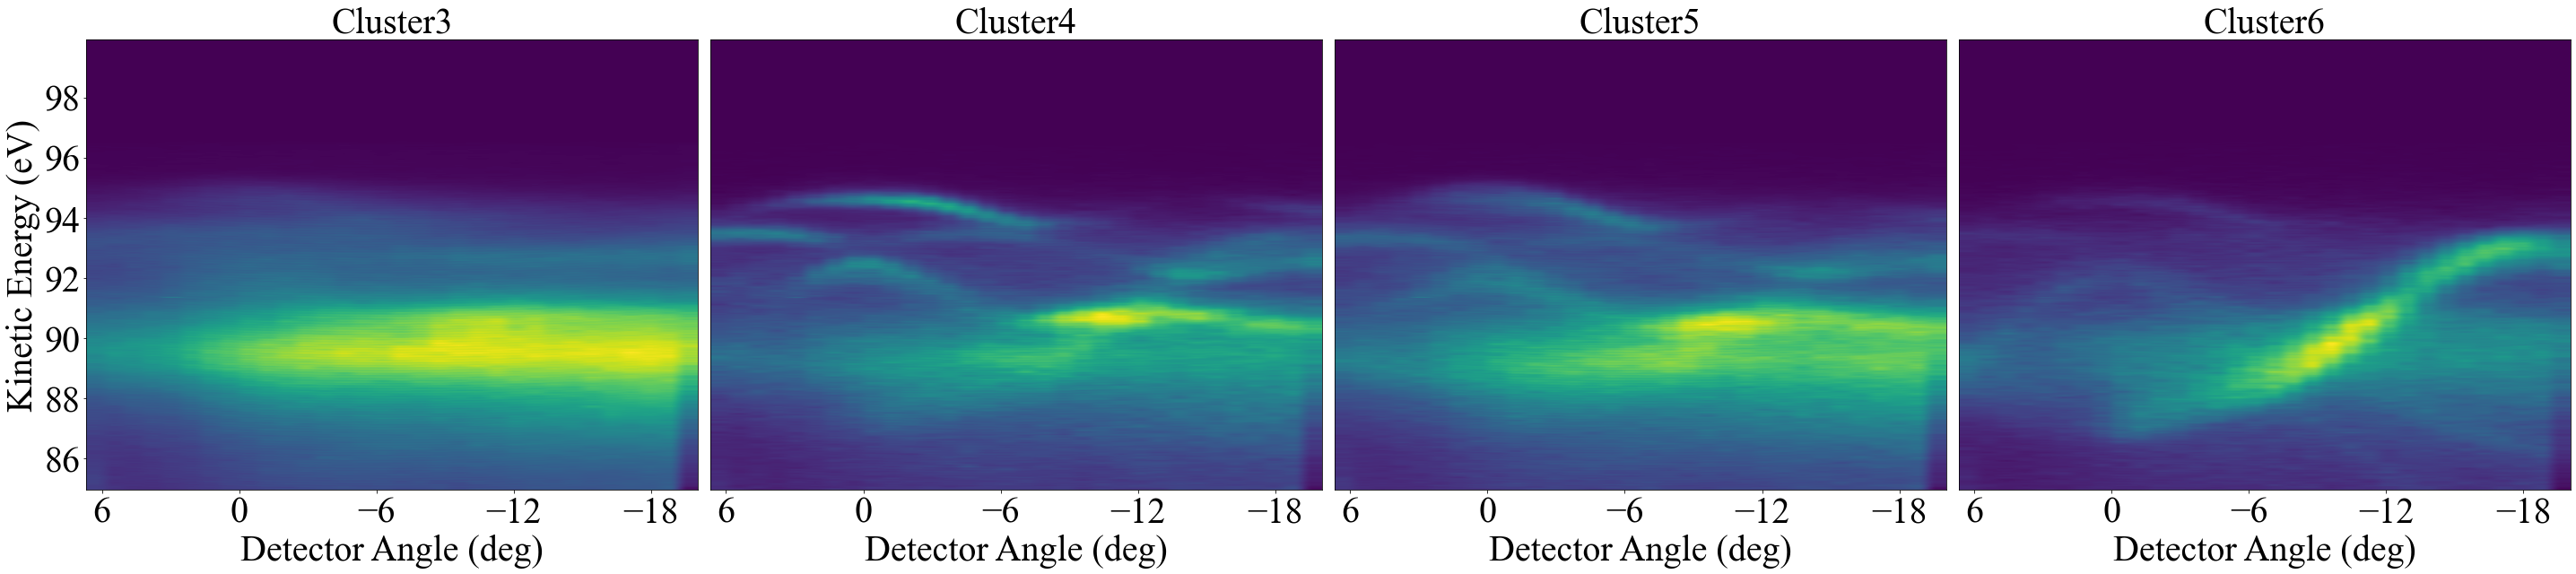

In [79]:
nk = 4
result,fig,x_list, y_list, new_km_results_of_chosen_cluster = clustering_and_visualization(nk,iEDCs_of_target_cluster,x_cluster,y_cluster,km_results_of_chosen_cluster,label_mapping={1:0, 0:1, 2:2, 3:3})

### only suitable for cluster_chosen = 2
label_all = np.sum([km_results_of_each_cluster[0], km_results_of_each_cluster[1], new_km_results_of_chosen_cluster[0], new_km_results_of_chosen_cluster[1], new_km_results_of_chosen_cluster[2], new_km_results_of_chosen_cluster[3]], axis=0)
calculate_accuracy("Accuracy of nk = 4 and momentum space of nk = 3 and engbin40 and angbin40: ", label_all, label_mapping = None)

x_of_each_cluster = [x_nk3[0], x_nk3[1], x_list[0], x_list[1], x_list[2], x_list[3]]
y_of_each_cluster = [y_nk3[0], y_nk3[1], y_list[0], y_list[1], y_list[2], y_list[3]]
fig = clustering_and_visualization_alldata(x_of_each_cluster, y_of_each_cluster)
fig.savefig(f'{plotfolder}/plot_3-4.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/plot_3-4.png', dpi=300, bbox_inches='tight')

fig = iARPESs_cluster_visualization(nk,result,iARPESs_cluster,ang_ini,ang_end,eng_ini,eng_end)
fig.savefig(f'{plotfolder}/ARPES_3-4.pdf', dpi=300)
fig.savefig(f'{plotfolder}/ARPES_3-4.png', dpi=300)